In [1]:
import os

import numpy as np
import pandas as pd

from toolkit.scrape import Govdocs1Api
from toolkit.utils import get_file_types, get_1st_block_bytes, get_2nd_block_bytes, get_last_block_bytes, \
    print_50bytes_1st_block, print_50bytes_body_block, print_50bytes_last_block, convert_cat2num, \
    byte_frequency_histogram, pad_array
from toolkit.visuals import barplot_file_distribution, piechart_file_distribution, scatter_file_sizes, \
    boxplot_file_sizes, plot_byte_grey_scale, plot_byte_value_distribution, correlation_matrix_heatmap, \
    plot_pca, plot_tsne

### Downloading the dataset

In [2]:
downloader = Govdocs1Api(start_sample=0, end_sample=4)

In [3]:
downloader.download_dataset()

Starting the download. The process might take some time.
000.zip downloaded. 1/4 (25.00%)
001.zip downloaded. 2/4 (50.00%)
002.zip downloaded. 3/4 (75.00%)
003.zip downloaded. 4/4 (100.00%)
Dataset download completed successfully.


### Exploring the dataset

In [4]:
dir_path = 'govdocs1/'
files_data = get_file_types(dir_path)
df = pd.DataFrame(files_data)

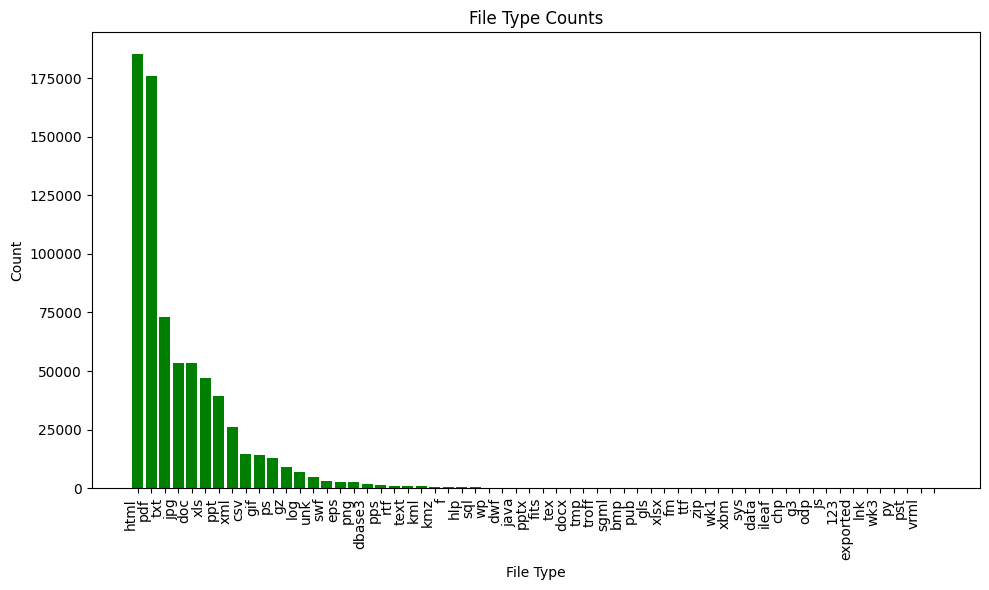

In [5]:
barplot_file_distribution(df)

In [6]:
# file sizes in KB
df['size KB'] = df['file'].apply(lambda x: float(os.path.getsize(
    os.path.join(os.getcwd(), f"govdocs1/{x}")
) / 1024) if os.path.isfile(
    os.path.join(os.getcwd(), f"govdocs1/{x}")
) else None)

print(f"The average file size is: {df['size KB'].mean()} KB")
print(f"The maximum file size is: {df['size KB'].max()} KB")
print(f"The minimum file size is: {df['size KB'].min()} KB")

The average file size is: 519.8767892054933 KB
The maximum file size is: 1594448.5634765625 KB
The minimum file size is: 0.0068359375 KB


In [7]:
# target file types
CLASS_NAMES = [
    "doc",
    "pdf",
    "ps",
    "xls",
    "ppt",
    "swf",
    "gif",
    "jpg",
    "png",
    "html",
    "txt",
    "xml"
]

In [8]:
df = df[df['type'].isin(CLASS_NAMES)]
df = df[df['size KB'] > 16]
df['type'].value_counts()

type
pdf     168373
html    110537
doc      52927
xls      45050
txt      42195
jpg      41034
ppt      39412
xml      13837
ps       12275
gif       8412
swf       2694
png       1356
Name: count, dtype: int64

In [9]:
# sample the target file types
df = df.groupby('type').apply(
    lambda x: x if x.name == "png" else x.sample(n=min(len(x), 2000), random_state=42)
).reset_index(drop=True)

df["type"].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_11372\3309657051.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('type').apply(


type
doc     2000
gif     2000
html    2000
jpg     2000
pdf     2000
ppt     2000
ps      2000
swf     2000
txt     2000
xls     2000
xml     2000
png     1356
Name: count, dtype: int64

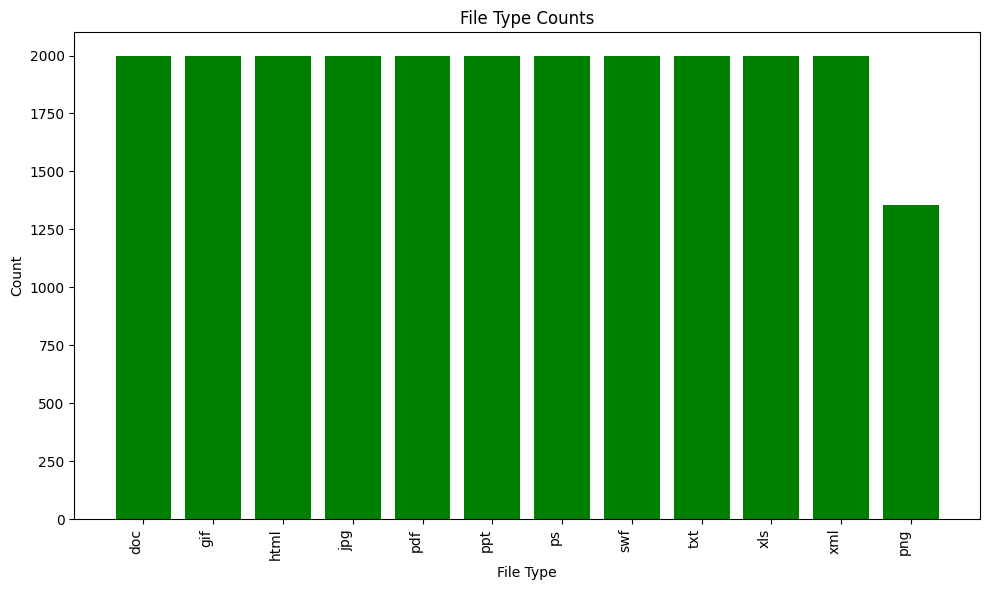

In [10]:
barplot_file_distribution(df)

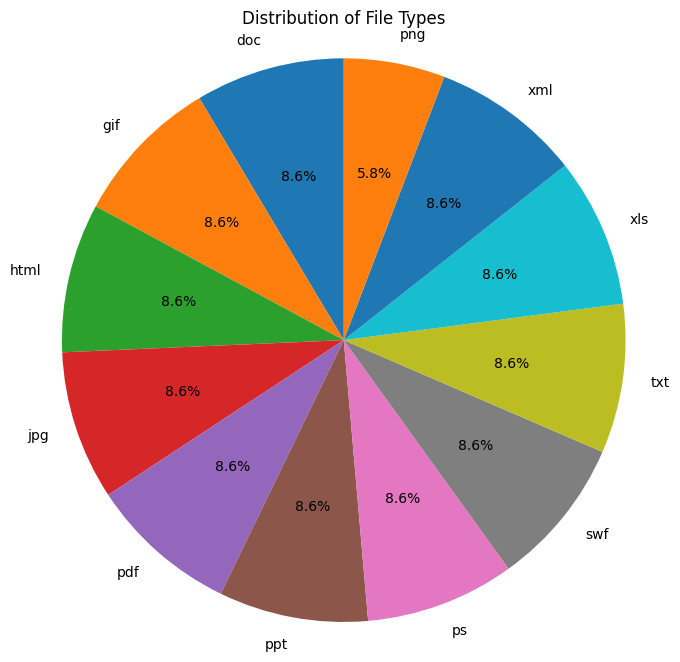

In [11]:
piechart_file_distribution(df)

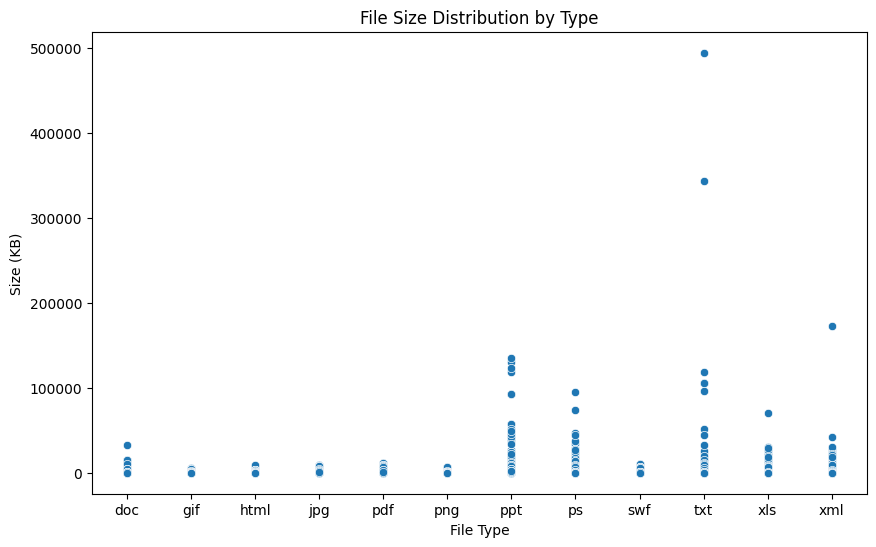

In [12]:
scatter_file_sizes(df)

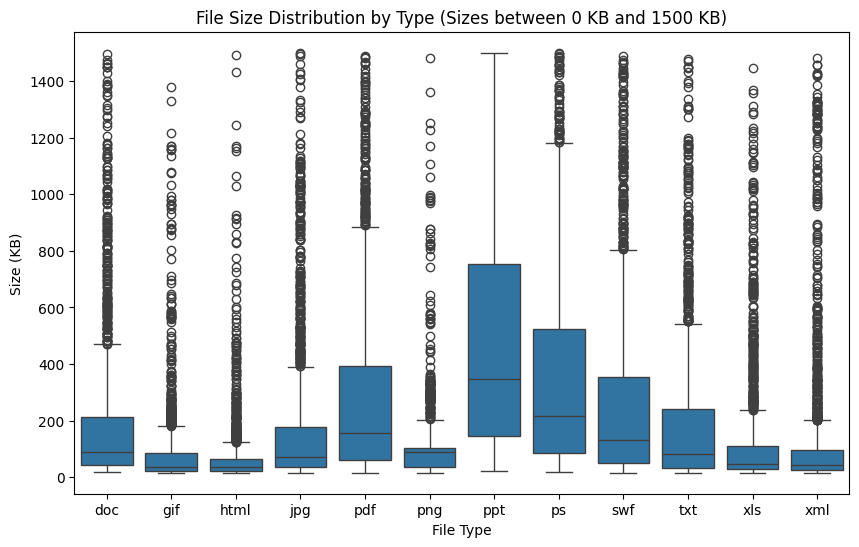

In [13]:
boxplot_file_sizes(df, size_min=0, size_max=1500)

In [14]:
df.sample(n=10)

,file,type,size KB
7789,253595.jpg,jpg,133.910156
12512,211957.ppt,ppt,157.000000
1281,195252.doc,doc,87.000000
596,051900.doc,doc,2526.500000
15886,579380.swf,swf,462.514648
13787,226707.ps,ps,5091.653320
18205,058506.txt,txt,336.898438
8189,047086.pdf,pdf,329.173828
16568,580443.swf,swf,299.404297
16524,640013.swf,swf,6814.873047


### Extracting the first, body, and last byte blocks (represented in ASCII)

In [15]:
base_dir = os.path.join(os.getcwd(), "govdocs1")

In [16]:
df["1st_block_bytes"] = df["file"].apply(
    lambda file: get_1st_block_bytes(os.path.join(base_dir, file))
)

In [17]:
df["body_block_bytes"] = df["file"].apply(
    lambda file: get_2nd_block_bytes(os.path.join(base_dir, file))
)

In [18]:
df["last_block_bytes"] = df.apply(
    lambda row: get_last_block_bytes(
        path=os.path.join(base_dir, row["file"]), 
        file_size_kb=row["size KB"]
    ), 
    axis=1
)

In [19]:
df.sample(n=10)

,file,type,size KB,1st_block_bytes,body_block_bytes,last_block_bytes
17594,544077.txt,txt,389.735352,b' date/time P elap grid htMSL pres dir...,b'29000000024 3.472\r\n20081017 0042 F ...,b'078 1316.421\r\n20081019 2356 F 4316 0GCP...
11420,263337.ppt,ppt,1724.500000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,b'\x03\xd3\x14\x07\xb4\xcb-\xbfw\xa6\xd9\xedY\...,b'P\x00o\x00w\x00e\x00r\x00P\x00o\x00i\x00n\x0...
4435,380327.html,html,103.703125,"b'<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01...","b'src=""corehtml/pmc/pmcgifs/logo-bmcmd.gif"" al...",b'amp;&amp;http://www.ncbi.nlm.nih.gov/pubmed/...
17351,287449.swf,swf,29.958984,b'FWS\x04\xd6w\x00\x00x\x00\x05\xfa\x00\x00\x1...,b'\xcc\xb2`\x07\xca\x85\x89\xaa\x16!\x00=*\xfc...,b'K (\x90\x0c6\xda^\xdd\xad\xf7\x9e\xad\xdb\xe...
14463,442941.ps,ps,399.148438,b'%!PS-Adobe-2.0\n%%Creator: dvips(k) 5.86 Cop...,b'2 w}B/s{p 3 w}B/t{p 4 w}B/x{0 S\nrmoveto}B/y...,b' d 23 31 d 18 31 d 23 31 d 18 30 d 18 31 d 3...
1184,518881.doc,doc,33.500000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,b'out Buzzer System \rCan be loaned out from\x...,b'\x05\x00S\x00u\x00m\x00m\x00a\x00r\x00y\x00I...
8312,677788.pdf,pdf,481.182617,b'%PDF-1.6\r%\xe2\xe3\xcf\xd3\r\n1430 0 obj\r<...,b'00 500 350 500 1000 333 1000 389 333 722 350...,b'f\r\n0000000000 65535 f\r\n0000000000 65535 ...
13063,679259.ppt,ppt,634.500000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,b'\xdd\xf1\xd0U\xac\xea\xbcH\xf6\xf3\xa7\xd4U\...,b'\x81\x03\x00\x00\x82\x03\x00\x00\x83\x03\x00...
14083,668611.ps,ps,35.312500,b'%!PS-Adobe-2.0\n%%Creator: dvips(k) 5.86 Cop...,b'B/s{p 3 w}B/t{p 4 w}B/x{0 S\nrmoveto}B/y{3 2...,b'382 2102 V 164\nw(HV)i(on)p 1672 2102 V 2961...
2462,078037.gif,gif,231.264648,b'GIF87a\xdb\x02\xe8\x01\xf7\x00\x007m\xac\x0f...,"b'&i,\xc5R&%\x1eu\x82\x03\xfe\xf0\x10\x1d\xdf\...",b'\xc0K\xc8\x98\xe4\x1d\x85W$\x01\xca \x8d4\x8...


## ASCII Representations of Bytes

### doc files

In [20]:
print_50bytes_1st_block(df, "doc")
print_50bytes_body_block(df, "doc")
print_50bytes_last_block(df, "doc")

First block:
sample 1: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x01\x03'
sample 2: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\xa8\x00'
sample 3: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00u\x00'
sample 4: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\xfd\x00'
sample 5: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x0

### pdf files

In [21]:
print_50bytes_1st_block(df, "pdf")
print_50bytes_body_block(df, "pdf")
print_50bytes_last_block(df, "pdf")

First block:
sample 1: b'%PDF-1.3\r%\xe2\xe3\xcf\xd3\r\n136 0 obj\r<< \r/Linearized 1 \r/O 13'
sample 2: b'%PDF-1.4\n%\xaa\xab\xac\xad\n4 0 obj\n<<\n/Producer (Apache FOP Ve'
sample 3: b'%PDF-1.2\r%\xe2\xe3\xcf\xd3\r\n398 0 obj\r<< \r/Linearized 1 \r/O 40'
sample 4: b'%PDF-1.3\r%\xe2\xe3\xcf\xd3\r\n9 0 obj\r<< \r/Linearized 1 \r/O 11 \r'
sample 5: b'%PDF-1.4\r%\xe2\xe3\xcf\xd3\r\n18 0 obj\r<< /Filter /FlateDecode /'


Body block:
sample 1: b"\xb6\xef\x1c\x1e~?v\xd2\x18\x94'Z\xbcn{\xd7\xd8\x14\xa3{e\xf3\x9b\xbam\x0f\xd0\xe3\xb1\xb6\xbe\x80\xeaU(\xda\xd3k\xb6\xdb\x96\x93tW\xa3\x11\xe5\xdfW\x9b"
sample 2: b'e>\xf4\xa3]\xda\xe6\xf1\xf5e\xa6\x0fK\xd3\xff6\xbf\n\x0b\x82Se\xba9\xd5\xa8\xa9L\x01;\x82\xbe\xa8H\xf5P7[\xa4\xaek=\x0b\xcc\x1ac\x9d.\xcb\xa6'
sample 3: b'/StemV 48 \r/XHeight 465 \r/StemH 28 \r/CharSet (/A/n'
sample 4: b'u\x11\xad\xf8\x0c\x1d\x8cB;\xf4\xe5\xec\xfdL\x13\xf9\xbc7r\xc7\xbd\x81\x8f(\x96\xb1sP*e\xd2`Ff\x1cM\xa4)4\x9b\x91\\J\x9biG$\xf7}t'
sample 5: b'\xaa\x9f\xa8\xfb\x80#\x

### ps files

In [22]:
print_50bytes_1st_block(df, "ps")
print_50bytes_body_block(df, "ps")
print_50bytes_last_block(df, "ps")

First block:
sample 1: b'%!PS-Adobe-2.0\n%%Creator: dvips(k) 5.85 Copyright '
sample 2: b'%!PS-Adobe-\n%%BoundingBox:    36   36  576  756\n%%'
sample 3: b'%!PS-Adobe-2.0\n%%Creator: dvips(k) 5.86 Copyright '
sample 4: b'%!PS-Adobe-3.0\n%%BoundingBox: 0 0 1728 2592\n%%Titl'
sample 5: b'%!PS-Adobe-2.0\n%%Creator: dvips 5.54 Copyright 198'


Body block:
sample 1: b' M}B/e{-2 M}B/f{-1 M}B/g{0 M}\nB/h{1 M}B/i{2 M}B/j{'
sample 2: b'nt [   0.00  21.60 -21.60   0.00 0. 0.] makefont s'
sample 3: b'r{p 2 w}B/s{p 3 w}B/t{p 4 w}B/x{0 S\nrmoveto}B/y{3 '
sample 4: b'g exch 0.866025 mul D P V C F U S} bind def\n/T4 {M'
sample 5: b'moveto}B /M{S p delta add tail}B /b{S p tail}\nB /c'


Last block:
sample 1: b'ler\nend\nuserdict /end-hook known{end-hook}if\n%%EOF'
sample 2: b'e newpath\n%gend\nstroke\nshowpage\n%endp\n%gdone\n%%EOF'
sample 3: b'ler\nend\nuserdict /end-hook known{end-hook}if\n%%EOF'
sample 4: b'7 4.16667 scale 0 A\nshowpage\n\n%%Trailer\n\nend\n%%EOF'
sample 5: b'ler\nend\nuserdict /en

### xls files

In [23]:
print_50bytes_1st_block(df, "xls")
print_50bytes_body_block(df, "xls")
print_50bytes_last_block(df, "xls")

First block:
sample 1: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00@\x01'
sample 2: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00<\x00'
sample 3: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x007\x00'
sample 4: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x81\x00'
sample 5: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\

### ppt files

In [24]:
print_50bytes_1st_block(df, "ppt")
print_50bytes_body_block(df, "ppt")
print_50bytes_last_block(df, "ppt")

First block:
sample 1: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0\x00\x00\x00\x84O'
sample 2: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x15\x00\x00\x00_\n'
sample 3: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00,\x00\x00\x00\xb8\x15'
sample 4: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x9a\x00'
sample 5: b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x03\x00\xfe\xff\t\x00\x06\x00\x00\x00\x00\x00\x0

### swf files

In [25]:
print_50bytes_1st_block(df, "swf")
print_50bytes_body_block(df, "swf")
print_50bytes_last_block(df, "swf")

First block:
sample 1: b'CWS\x06h\x9a\x00\x00x\x9c\xec\xbbeT\x1c\xdf\xbb\xef\xd9\x04\r\xc1%\xc1\xb5\xd1\x06\x82\x04\xb7\x10\x824\x04ww\x0f\xee\x16,@\x80\xc6\x1a\x0b\xd6\x04\x0b\xda\xb8'
sample 2: b'CWS\x06\x8a\xdd\n\x00x\x9c\xcc\xb9uX\xd4]\xf4/\xfa\x9d \x86\x12\xc9\x97FR@\xbaA`@@\x1a\xa4S\xba\x19\xba\x11\x18\x10\x03\x04\xa5;U:\xa5\x9b'
sample 3: b'CWS\x06J{\x01\x00x\x9c\xdc\xb9g\\\x14M\xb7\xe8[\x13\xc8\xa8\xe4\x0c\x0e9g\x01\x01\xc3\x80\xe4\x9c\xb3\x88H\x8e\n\x02\xf2 :*""JN"\x92s'
sample 4: b'CWS\x073f\x01\x00x\x9c\xec\xbau\\\x94\xdb\xb78\xfc\x0c\r\xd2!%\xa14\x08\x8a\x804\x03* %\xdd\xa9tw\x83\x83\x82\xa0t\x08H\xa3t\x0c% '
sample 5: b'CWS\x06\x85\'\x03\x00x\x9c\xe4\xba\x05TU\xdf\xb7?\xba\xcf\x81Cw\x83\x94\x92\xd2)]"\xad4H\x87\xe4\xa1\xbb\x91#\x88\n"\xdd\xdd\x87F@\xba\xa5A'


Body block:
sample 1: b"im\x8d'\x01\x0fB;3\xda\x08\xda\xe6J\x8a\xdc\x11\xfd\xc4\xd2PV\xf3\x9b\xce\x17\x00\xe6nl\x8a\x02\xbe\x9e\x9f\x193\xa3\xa3UYuW=z\xbb\x97\xed\x97@"
sample 2: b'\x8eig\xc9\xd4\x96\xb1\xc7\x8f\xed\

### gif files

In [26]:
print_50bytes_1st_block(df, "gif")
print_50bytes_body_block(df, "gif")
print_50bytes_last_block(df, "gif")

First block:
sample 1: b'GIF89aE\x04(\x02\x80\x00\x00\x00\x00\x00\xff\xff\xff,\x00\x00\x00\x00E\x04(\x02@\x02\xff\x0c\x8e\t\xc1\xed\xe8"\x8c\xb4\xda\xcb\x14\xd5\xd8\xc2\xd9\x85\xd2!'
sample 2: b'GIF87aX\x02\x90\x01\xf7\x00\x00\xff\xff\xff\xeb\xf5\xf0\xd2\xe6\xe6\x96\xf0\xf5-\xe1\xd2-\xe1dF\xeb7_\xf5\n\x8c\xff\x00\xbe\xff\x00\xe6\xfa\x00\xf5\xff\x00\xff'
sample 3: b'GIF87a\x84\x03\xb0\x04\xf7\x00\x00\x00\x00\x00\x80\x80\x80\xff\x00\x00\xff\xff\x00\x00\xff\xff\x00\x00\xff\xff\x00\xff\xff\xff\xff\x00\xff\x00\xc8\xc8\xc8\x00\x00\x00\x00\x00\x00\x00'
sample 4: b'GIF87a\x93\x03\xcb\x01\xe7\x00\x00\x00\x00\x00\x00\xeb\xeb\x00\xa3\xf7\x00\x00\xf7\x00\xff\x00\x00\xc7\x00\x00\x8f\x00\x00O\x00\xff\xff\x00\xff\x8f\x00\xff\x00\x00\xd7\x00\x00\xbf'
sample 5: b'GIF87a\xd0\x02X\x02\xf7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc8\xc8\xc8\xc8\xc8\xc8\xc8'


Body block:
sample 1: b';\xaf\x04\xf2e\xaa+\xbeY\x0b8\xba\x0

### jpg files

In [27]:
print_50bytes_1st_block(df, "jpg")
print_50bytes_body_block(df, "jpg")
print_50bytes_last_block(df, "jpg")

First block:
sample 1: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00d\x00d\x00\x00\xff\xec\x00\x11Ducky\x00\x01\x00\x04\x00\x00\x00<\x00\x00\xff\xee\x00\x0eAdobe\x00d'
sample 2: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00d\x00d\x00\x00\xff\xec\x00\x11Ducky\x00\x01\x00\x04\x00\x00\x00<\x00\x00\xff\xee\x00\x0eAdobe\x00d'
sample 3: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\xb4\x00\xb4\x00\x00\xff\xfe\x00VNASA Langley Research Cent'
sample 4: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01'
sample 5: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00d\x00d\x00\x00\xff\xec\x00\x11Ducky\x00\x01\x00\x04\x00\x00\x00E\x00\x00\xff\xee\x00\x0eAdobe\x00d'


Body block:
sample 1: b'd\x170\x00\xf6c\xd3\xc6x7+U\xcb?\xa7\x1a\x90`\x8f\x1c\x00{\x9e\x01\x18\xf0\xc0\x06\x83\x96\x01\x8d6\xabXc\x97\xe2.\xe0\x13\xc2\xc8zP\x16+\xa9\xaa\x08'
sample 2: 

### png files

In [28]:
print_50bytes_1st_block(df, "png")
print_50bytes_body_block(df, "png")
print_50bytes_last_block(df, "png")

First block:
sample 1: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xb2\x00\x00\x01\xb8\x08\x02\x00\x00\x00\xf7\xe6L\xec\x00\x00\x00\tpHYs\x00\x00\x00\x00\x00\x00\x00\x00\x00'
sample 2: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01h\x00\x00\x01\x14\x08\x06\x00\x00\x00\x06\x05\xaco\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00'
sample 3: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x032\x00\x00\x01\xf9\x08\x06\x00\x00\x00Z\x85\x0bs\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04'
sample 4: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02:\x00\x00\x01\xde\x08\x03\x00\x00\x00\xa5\xabQ\xfb\x00\x00\x02\xacPLTEa\x00af\x00ik\x00q'
sample 5: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01\xe0\x08\x03\x00\x00\x00\x02\x0f,\xd6\x00\x00\x00\x03sBIT\x08\x08\x08\xdb\xe1O\xe0\x00\x00'


Body block:
sample 1: b'1`\xf5\xd8p\xbaN\xc6\xa5\xb2\x9d\xaaUN\x0f\xa5\xcf\x8eU\xca\x06k\x89i\xaec\xeb>\xd5q\xdcL:+\\T3\xbc\xf6\xf6\x84$\x91|\xa9\xaa\xa9\x8a\xa4P'
sample 2: b'

### html files

In [29]:
print_50bytes_1st_block(df, "html")
print_50bytes_body_block(df, "html")
print_50bytes_last_block(df, "html")

First block:
sample 1: b'\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n \r\n\r\n  \r\n\r\n\r\n  \r\n\r\n\r\n  \r\n\r\n\r\n\r\n\r'
sample 2: b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Trans'
sample 3: b'<HTML>\r\n\r\n<TITLE>{ 2000/10/30 TIME: 17-30 , Mon. 1'
sample 4: b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final/'
sample 5: b'<HTML>\r\n<HEAD>\r\n<STYLE TYPE="text/css">\r\n<!--\r\nbod'


Body block:
sample 1: b'earch.cfm" title="Database of laboratory testing s'
sample 2: b' alt="Logo of jcardsurg" usemap="#logo-imagemap"><'
sample 3: b'EL. WAIT A MINUTE, THIS IS MOVING IN THE OPPOSITE\r'
sample 4: b'when you get outside \nof the political arena and y'
sample 5: b'p width=50%></td>\r\n</tr></table></SPAN>\r\n</tr></ta'


Last block:
sample 1: b'm -->\r\n</TD></TR>\r\n</TABLE>\r\n\r\n</body>\r\n</html>\r\n\r'
sample 2: b'</td></tr></table></body></html><!--host:ipmc3-->\n'
sample 3: b'ENT]" WIDTH="60" HEIGHT="40" BORDER="2">\r\n</HTML>\r'
sample 4: b'ONG>END4:18 P.M. EDT</STRONG>\n\n\n\n

### txt files

In [30]:
print_50bytes_1st_block(df, "txt")
print_50bytes_body_block(df, "txt")
print_50bytes_last_block(df, "txt")

First block:
sample 1: b'**************************************************'
sample 2: b'\n\nHEADER    HYDROLASE(ACID PROTEINASE)            '
sample 3: b'--------------------------------------------------'
sample 4: b'From: Rich Murray [rmforall@att.net]\r\nSent: Monday'
sample 5: b'Export Name|PCHA/FireFamily Plus\r\nVersion|2.0\r\nCre'


Body block:
sample 1: b'  773.0  -23.7*   766.2    11\nDF-00114   123  6505'
sample 2: b'                 40         1SIP  52\nREMARK   4   '
sample 3: b'                 \n\t given below:                  '
sample 4: b'me,\r\n14C-labeled in the methanol carbon. At timed '
sample 5: b'BLM|AZ|AZYUD|GILA||9838|1|1|11/24/1980 13:30|11/24'


Last block:
sample 1: b' 83  640727-640803     919.0  -26.4*   922.3    11'
sample 2: b'                                          1SIP 930'
sample 3: b'                                                  '
sample 4: b'*********************************************\r\n\r\n\r'
sample 5: b'LARM 12||C9F8|5|6|07/19/2007||||

### xml files

In [31]:
print_50bytes_1st_block(df, "xml")
print_50bytes_body_block(df, "xml")
print_50bytes_last_block(df, "xml")

First block:
sample 1: b'<rdf:RDF\n    xmlns:j.0="http://xmdr.org/ont/iso111'
sample 2: b'<?xml version="1.0"?>\r\n<metadata><Source>http://wa'
sample 3: b'<rdf:RDF\n    xmlns:j.0="http://xmdr.org/ont/iso111'
sample 4: b'<?xml version="1.0"?>\r\n<metadata><Source>http://fr'
sample 5: b'<?xml version="1.0" encoding="ISO-8859-1"?>\r\n<meta'


Body block:
sample 1: b'/xmdr.org/ont/iso11179-3e3draft_r4.owl#Facet"/>\n  '
sample 2: b'h a digital\r\nrepresentation of the shoreline to pr'
sample 3: b'_Thesaurus/L/Gene_Product_Encoded_By_Gene/NCI_Thes'
sample 4: b'\n<taxonrv>Mammalia</taxonrv>\r\n<common>mammals</com'
sample 5: b'ng.  These data are not intended to be used for na'


Last block:
sample 1: b'#Identification"/>\n  </rdf:Description>\n</rdf:RDF>'
sample 2: b'-STD-001-1998</metstdv>\r\n</metainfo>\r\n</metadata>\r'
sample 3: b'#Identification"/>\n  </rdf:Description>\n</rdf:RDF>'
sample 4: b'ettc>local time</mettc>\r\n</metainfo>\r\n</metadata>\r'
sample 5: b' </instinfo>\r\n  \r\n 

## Hexadecimal Representations of Bytes

In [32]:
# convert file types (categorical) to numerical
df["class"] = df["type"].apply(lambda file_type: convert_cat2num(file_type))
df_subset = df.groupby('class').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)
df_subset.sample(n=10)

C:\Users\User\AppData\Local\Temp\ipykernel_11372\1480470402.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_subset = df.groupby('class').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)


,file,type,size KB,1st_block_bytes,body_block_bytes,last_block_bytes,class
286,564746.swf,swf,264.298828,b'FWS\x052!\x04\x00x\x00\x05_\x00\x00\x0f\xa0\...,b'\x80\n(\xa2\x80\n(\xa2\x80\n(\xa2\x80\n(\xa2...,b'\x08\x05N\x96\x04\x00\x08\r\x08\x00\x1c\x96\...,6
96,648731.pdf,pdf,1484.868164,b'%PDF-1.4\r%\xe2\xe3\xcf\xd3\r\n739 0 obj\r<<...,b'Parent 747 0 R \r/Dest << /Type /Action /S /...,b'8 00000 n\r\n0001490775 00000 n\r\n000149116...,2
422,371172.png,png,18.200195,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\xf7\xef\xdd}\xe3\xdd\xfbw\xdec\xc9\xd9\xeb\...,b'\xf0\xea\'\x952Z\xfa\x91\x8b\x1f;\xfd\x86W\x...,9
38,673150.doc,doc,28.500000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,"b"" Manchester 6 Merrimack ...",b'\x01\x00\xfe\xff\x03\n\x00\x00\xff\xff\xff\x...,1
385,358749.jpg,jpg,32.708008,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,b'\x95\xbb\xe5px\xa64F\xa1Vhn\x07<\x05\xd5\xbb...,b'\x14P\x01E\x14P\x01E\x14P\x01E\x14P\x01E\x14...,8
520,246441.txt,txt,49.486328,"b""\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n ...","b'YCHOL)\n ,,/,TOWNSEND, RONNIE (...","b"" Brooklyn, N.Y. 11218.\n ...",11
570,604629.xml,xml,57.568359,"b'<rdf:RDF\n xmlns:j.0=""http://xmdr.org/ont...","b'df:resource=""http://bambam.lbl.gov:8080/xmdr...","b'anguage rdf:datatype=""http://www.w3.org/2001...",12
484,474598.html,html,18.931641,"b'<html>\n<head>\n <meta http-equiv=""Pragma"" ...",b' <td align=center valign=bottom>\n ...,b'br>\n<a class=mail href=JavaScript:OpenLastE...,10
171,715258.xls,xls,41.500000,b'\xd0\xcf\x11\xe0\xa1\xb1\x1a\xe1\x00\x00\x00...,b' \x04\x02\x13\x00\x06\x00\x03\x00\x19\x...,b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...,4
598,585509.xml,xml,24.012695,"b'<rdf:RDF\n xmlns:j.0=""http://xmdr.org/ont...","b'4.owl#Identified_Item""/>\n <j.0:Facet.fac...",b'>\n</rdf:RDF>\n',12


In [33]:
df_subset["type"].value_counts()

type
doc     50
pdf     50
ps      50
xls     50
ppt     50
swf     50
gif     50
jpg     50
png     50
html    50
txt     50
xml     50
Name: count, dtype: int64

In [34]:
def create_block_df(X_block: np.ndarray, y_block: np.ndarray) -> pd.DataFrame:
    """
    Creates a dataframe for a given block (first, body, or last).
    The shape of the byte and file type array has to be consistent.

    Args:
        X_block (np.ndarray): The 2D array of bytes.
        y_block (np.ndarray): The 1D array of file types.
    Returns:
        pd.DatafFrame: The block dataframe.
    """
    block_df = pd.DataFrame(X_block)
    column_names = [f'byte_{i}' for i in range(X_block.shape[1])]
    block_df.columns = column_names
    block_df['type'] = y_block
    return block_df

In [35]:
# file types of the file samples
TYPE_BLOCK = np.array([y for y in df_subset["type"]])

### 1. First Block

In [36]:
X_first_block = np.array([np.array([b for b in x]) for x in df_subset["1st_block_bytes"]])
X_hex_first_block = np.array([np.array([hex(b) for b in x]) for x in df_subset["1st_block_bytes"]])
y_first_block = np.array([y for y in df_subset["class"]])

first_block_df = create_block_df(X_hex_first_block, TYPE_BLOCK)
first_block_df.sample(10)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,...,byte_4087,byte_4088,byte_4089,byte_4090,byte_4091,byte_4092,byte_4093,byte_4094,byte_4095,type
113,0x25,0x21,0x50,0x53,0x2d,0x41,0x64,0x6f,0x62,0x65,...,0x66,0xa,0x20,0x20,0x20,0x20,0x20,0x70,0x61,ps
247,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,...,0x61,0x0,0x20,0x0,0x70,0x0,0x72,0x0,0x6f,ppt
525,0x30,0x36,0x63,0x30,0x32,0x5f,0x62,0x9,0x20,0x31,...,0x30,0x30,0x36,0x9,0x31,0x39,0x39,0x3a,0x31,txt
187,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,...,0x4d,0x0,0x4e,0x3,0x0,0x0,0x41,0x63,0x72,xls
566,0x3c,0x3f,0x78,0x6d,0x6c,0x20,0x76,0x65,0x72,0x73,...,0x2d,0x69,0x64,0x3d,0x22,0x57,0x30,0x30,0x30,xml
215,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,...,0xd1,0x43,0x72,0xf0,0x17,0xe1,0x82,0x34,0x25,ppt
209,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,...,0x65,0x75,0x85,0x95,0xa5,0xb5,0xc5,0xd5,0xe5,ppt
217,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,...,0xdf,0xb,0xa2,0xb7,0x8d,0xe6,0x8a,0x1,0xb8,ppt
367,0xff,0xd8,0xff,0xe0,0x0,0x10,0x4a,0x46,0x49,0x46,...,0x46,0xdb,0x2c,0x8f,0xf3,0xf2,0x7e,0x5e,0x8,jpg
173,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,...,0x20,0x6f,0x66,0x20,0x41,0x6c,0x6c,0x65,0x72,xls


In [37]:
BYTES_DISPLAY_NO = 15
# the file types with magic numbers:
DOC_MAGIC_NO = 8
PDF_MAGIC_NO = 4
PS_MAGIC_NO  = 4
XLS_MAGIC_NO = 8
PPT_MAGIC_NO = 8
SWF_MAGIC_NO = 3
GIF_MAGIC_NO = 6
JPG_MAGIC_NO = 12
PNG_MAGIC_NO = 8

In [38]:
def highlight_magic_numbers(column: pd.Series, magic_no: int) -> list:
    """
    Highlights bytes in green if they are magic numbers.
    
    Args:
        column (pd.Series): The column of bytes to be styled.
        magic_no (list): The number of magic numbers.
    Returns:
        pd.Series: The Series with style applied.

    """
    return ['color: green' if column.name in [f'byte_{i}' for i in range(magic_no)] else '' for _ in column]


def get_1st_bytes_1st_block(file_type: str, magic_no: int) -> pd.DataFrame:
    """ 
    Creates a bytes dataframe where the magic numbers of a given file 
    type are in green. Displays 5 samples to ensure consistency.

    Args:
        file_type (str): The file type.
        magic_no (int): The number of magic numbers.
    Returns:
        pd.DataFrame: A dataframe of hexadecimal bytes.

    """
    return first_block_df[first_block_df['type'] == file_type][[f'byte_{i}' for i in range(BYTES_DISPLAY_NO)]] \
    .sample(n=5).style.apply(
        highlight_magic_numbers, magic_no=magic_no
    )

### pdf files

In [39]:
get_1st_bytes_1st_block("pdf", PDF_MAGIC_NO)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,byte_12,byte_13,byte_14
92,0x25,0x50,0x44,0x46,0x2d,0x31,0x2e,0x32,0xa,0x25,0xc7,0xec,0x8f,0xa2,0xa
82,0x25,0x50,0x44,0x46,0x2d,0x31,0x2e,0x33,0xd,0x25,0xe2,0xe3,0xcf,0xd3,0xd
73,0x25,0x50,0x44,0x46,0x2d,0x31,0x2e,0x34,0xd,0x25,0xe2,0xe3,0xcf,0xd3,0xd
70,0x25,0x50,0x44,0x46,0x2d,0x31,0x2e,0x34,0xd,0x25,0xe2,0xe3,0xcf,0xd3,0xd
94,0x25,0x50,0x44,0x46,0x2d,0x31,0x2e,0x34,0xd,0x25,0xe2,0xe3,0xcf,0xd3,0xd


### ps files

In [40]:
get_1st_bytes_1st_block("ps", PS_MAGIC_NO)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,byte_12,byte_13,byte_14
130,0x25,0x21,0x50,0x53,0x2d,0x41,0x64,0x6f,0x62,0x65,0x2d,0x32,0x2e,0x30,0x20
107,0x25,0x21,0x50,0x53,0x2d,0x41,0x64,0x6f,0x62,0x65,0x2d,0x32,0x2e,0x30,0xa
111,0x25,0x21,0x50,0x53,0x2d,0x41,0x64,0x6f,0x62,0x65,0x2d,0x33,0x2e,0x30,0xd
108,0x25,0x21,0x50,0x53,0x2d,0x41,0x64,0x6f,0x62,0x65,0x2d,0x32,0x2e,0x30,0xa
114,0x25,0x21,0x50,0x53,0x2d,0x41,0x64,0x6f,0x62,0x65,0x2d,0x32,0x2e,0x30,0xa


### doc files

In [41]:
get_1st_bytes_1st_block("doc", DOC_MAGIC_NO)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,byte_12,byte_13,byte_14
34,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
35,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
9,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
43,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
2,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0


### xls files

In [42]:
get_1st_bytes_1st_block("xls", XLS_MAGIC_NO)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,byte_12,byte_13,byte_14
175,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
182,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
188,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
179,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
164,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0


### ppt files

In [43]:
get_1st_bytes_1st_block("ppt", PPT_MAGIC_NO)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,byte_12,byte_13,byte_14
218,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
243,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
242,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
208,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0
230,0xd0,0xcf,0x11,0xe0,0xa1,0xb1,0x1a,0xe1,0x0,0x0,0x0,0x0,0x0,0x0,0x0


### swf files

In [44]:
get_1st_bytes_1st_block("swf", SWF_MAGIC_NO)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,byte_12,byte_13,byte_14
299,0x43,0x57,0x53,0x8,0x92,0x83,0x2,0x0,0x78,0x9c,0xec,0xbc,0x7,0x58,0x54
251,0x43,0x57,0x53,0x6,0xe5,0x72,0x0,0x0,0x78,0x9c,0xcc,0xbb,0x65,0x58,0x5c
264,0x43,0x57,0x53,0x6,0x65,0x40,0x3,0x0,0x78,0x9c,0x8c,0x78,0x75,0x5c,0x54
283,0x46,0x57,0x53,0x5,0x69,0x4,0xb,0x0,0x78,0x0,0x5,0xef,0x40,0x0,0x14
289,0x43,0x57,0x53,0x7,0x2d,0x11,0x28,0x0,0x78,0x9c,0xec,0x7d,0x7,0x58,0x53


### gif files

In [45]:
get_1st_bytes_1st_block("gif", GIF_MAGIC_NO)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,byte_12,byte_13,byte_14
349,0x47,0x49,0x46,0x38,0x39,0x61,0xde,0x1,0x44,0x2,0xf3,0x0,0x0,0x0,0x0
329,0x47,0x49,0x46,0x38,0x39,0x61,0x3e,0x4,0xfd,0x1,0x80,0x0,0x0,0x0,0x0
316,0x47,0x49,0x46,0x38,0x39,0x61,0x90,0x1,0xfa,0x0,0xf7,0x0,0x0,0x0,0x0
334,0x47,0x49,0x46,0x38,0x39,0x61,0x46,0x1,0xb1,0x1,0xb3,0x0,0x0,0x62,0x43
305,0x47,0x49,0x46,0x38,0x37,0x61,0x0,0x2,0x0,0x2,0xf7,0x0,0x0,0x0,0x0


### jpg files

In [46]:
get_1st_bytes_1st_block("jpg", JPG_MAGIC_NO)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,byte_12,byte_13,byte_14
364,0xff,0xd8,0xff,0xe0,0x0,0x10,0x4a,0x46,0x49,0x46,0x0,0x1,0x1,0x1,0x1
357,0xff,0xd8,0xff,0xe0,0x0,0x10,0x4a,0x46,0x49,0x46,0x0,0x1,0x1,0x0,0x0
379,0xff,0xd8,0xff,0xe0,0x0,0x10,0x4a,0x46,0x49,0x46,0x0,0x1,0x2,0x1,0x1
377,0xff,0xd8,0xff,0xe0,0x0,0x10,0x4a,0x46,0x49,0x46,0x0,0x1,0x2,0x0,0x0
387,0xff,0xd8,0xff,0xe0,0x0,0x10,0x4a,0x46,0x49,0x46,0x0,0x1,0x2,0x1,0x0


### png files

In [47]:
get_1st_bytes_1st_block("png", PNG_MAGIC_NO)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,byte_12,byte_13,byte_14
419,0x89,0x50,0x4e,0x47,0xd,0xa,0x1a,0xa,0x0,0x0,0x0,0xd,0x49,0x48,0x44
414,0x89,0x50,0x4e,0x47,0xd,0xa,0x1a,0xa,0x0,0x0,0x0,0xd,0x49,0x48,0x44
426,0x89,0x50,0x4e,0x47,0xd,0xa,0x1a,0xa,0x0,0x0,0x0,0xd,0x49,0x48,0x44
436,0x89,0x50,0x4e,0x47,0xd,0xa,0x1a,0xa,0x0,0x0,0x0,0xd,0x49,0x48,0x44
432,0x89,0x50,0x4e,0x47,0xd,0xa,0x1a,0xa,0x0,0x0,0x0,0xd,0x49,0x48,0x44


### 2. Last Block

In [48]:
X_last_block = np.array([pad_array(np.array([b for b in x]), pad_value=None) for x in df_subset["last_block_bytes"]])
X_hex_last_block = np.array([pad_array(np.array([hex(b) for b in x]), pad_value=None) for x in df_subset["last_block_bytes"]])
y_last_block = np.array([y for y in df_subset["class"]])

last_block_df = create_block_df(X_hex_last_block, TYPE_BLOCK)
last_block_df.sample(10)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,...,byte_4087,byte_4088,byte_4089,byte_4090,byte_4091,byte_4092,byte_4093,byte_4094,byte_4095,type
180,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,...,None,None,None,None,None,None,None,None,None,xls
184,0x81,0x8,0x0,0x0,0x82,0x8,0x0,0x0,0x83,0x8,...,None,None,None,None,None,None,None,None,None,xls
160,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,0x0,...,None,None,None,None,None,None,None,None,None,xls
259,0x0,0x40,0x0,0x40,0x0,0xcb,0xa,0x5f,0x6e,0x6f,...,None,None,None,None,None,None,None,None,None,swf
222,0x6e,0x64,0x20,0x4f,0x75,0x74,0x72,0x65,0x61,0x63,...,None,None,None,None,None,None,None,None,None,ppt
564,0x53,0x43,0x29,0x22,0x20,0x70,0x61,0x72,0x74,0x79,...,None,None,None,None,None,None,None,None,None,xml
557,0x61,0x74,0x61,0x74,0x79,0x70,0x65,0x3d,0x22,0x53,...,None,None,None,None,None,None,None,None,None,xml
15,0x5,0x0,0x53,0x0,0x75,0x0,0x6d,0x0,0x6d,0x0,...,None,None,None,None,None,None,None,None,None,doc
397,0xf1,0x6a,0x4d,0x7b,0x71,0x74,0xb2,0x85,0x11,0x86,...,None,None,None,None,None,None,None,None,None,jpg
519,0x73,0x73,0x65,0x64,0x20,0x69,0x6e,0x20,0x54,0x68,...,None,None,None,None,None,None,None,None,None,txt


In [49]:
BYTES_DISPLAY_NO = 10

PDF_END_MARKERS = ["0x0A", "0x25", "0x25", "0x45", "0x4f", "0x46"]
PNG_END_MARKERS = ["0x49", "0x45", "0x4e", "0x44", "0xae", "0x42", "0x60", "0x82"]
JPG_END_MARKERS = ["0xff", "0xd9"]
GIF_END_MARKER  = ["0x3b"]
PS_END_MARKER   = ["0x25", "0x45", "0x4f", "0x46"]
DOC_END_MARKER  = ["0xf4", "0x39", "0xb2"]

In [50]:
def get_last_valid_bytes(row: pd.Series) -> list:
    """ 
    Gets the last non-null bytes from the last block.

    Args:
        row (pd.Series): A sequence of bytes.
    Returns:
        list: The last 10 valid bytes.
    """
    valid_bytes = [byte for byte in row[:-1] if byte is not None]
    return valid_bytes[-BYTES_DISPLAY_NO:] if len(valid_bytes) >= BYTES_DISPLAY_NO else valid_bytes


def highlight_end_markers(series: pd.Series, end_markers: list) -> pd.Series:
    """
    Highlights bytes in red if they match any of the end markers.
    
    Args:
        series (pd.Series): The series to be styled.
        end_markers (list): The Byte values to be highlighted.
    Returns:
        pd.Series: The Series with style applied.
    """
    def color_cells(value):
        if value in end_markers:
            return "color: red"
        return ""
    return series.apply(color_cells)


def get_last_bytes_last_block(file_type: str, end_markers: list) -> pd.DataFrame:
    """
    Creates a bytes dataframe where the end markers of a given file type 
    are in red. Displays 5 samples to ensure consistency.

    Args:
        file_type (str): The file type.
        end_markers (list): The list of hexadecimal end markers
    Returns:
        pd.DataFrame: The dataframe of hexadecimal bytes with style applied.
    """
    last_valid_bytes = last_block_df[last_block_df['type'] == file_type].apply(lambda row: get_last_valid_bytes(row), axis=1)
    df_last_bytes = pd.DataFrame(
        last_valid_bytes.tolist(), 
        columns=[f'last_byte_{i}' for i in range(len(last_valid_bytes.iloc[0]))]
    ).sample(5)

    return df_last_bytes.style.apply(
        highlight_end_markers, end_markers=end_markers, axis=0
    )

### pdf files

In [51]:
get_last_bytes_last_block("pdf", PDF_END_MARKERS)

,last_byte_0,last_byte_1,last_byte_2,last_byte_3,last_byte_4,last_byte_5,last_byte_6,last_byte_7,last_byte_8,last_byte_9
28,0x31,0x31,0x36,0xd,0x25,0x25,0x45,0x4f,0x46,0xd
15,0x34,0xd,0xa,0x25,0x25,0x45,0x4f,0x46,0xd,0xa
14,0x31,0x32,0x39,0xd,0x25,0x25,0x45,0x4f,0x46,0xd
22,0x31,0x37,0x38,0xd,0xa,0x25,0x25,0x45,0x4f,0x46
20,0x36,0xd,0xa,0x25,0x25,0x45,0x4f,0x46,0xd,0xa


### png files

In [52]:
get_last_bytes_last_block("png", PNG_END_MARKERS)

,last_byte_0,last_byte_1,last_byte_2,last_byte_3,last_byte_4,last_byte_5,last_byte_6,last_byte_7,last_byte_8,last_byte_9
30,0x0,0x0,0x49,0x45,0x4e,0x44,0xae,0x42,0x60,0x82
34,0x0,0x0,0x49,0x45,0x4e,0x44,0xae,0x42,0x60,0x82
27,0x0,0x0,0x49,0x45,0x4e,0x44,0xae,0x42,0x60,0x82
32,0x0,0x0,0x49,0x45,0x4e,0x44,0xae,0x42,0x60,0x82
17,0x0,0x0,0x49,0x45,0x4e,0x44,0xae,0x42,0x60,0x82


### jpg files

In [53]:
get_last_bytes_last_block("jpg", JPG_END_MARKERS)

,last_byte_0,last_byte_1,last_byte_2,last_byte_3,last_byte_4,last_byte_5,last_byte_6,last_byte_7,last_byte_8,last_byte_9
45,0x6c,0xd9,0xb3,0x66,0xcd,0x9b,0x36,0x7f,0xff,0xd9
48,0x46,0x51,0x72,0xb1,0x11,0x4d,0xf4,0x3f,0xff,0xd9
34,0xd9,0x96,0x1b,0xdd,0xa5,0x45,0x37,0x63,0xff,0xd9
7,0x77,0xad,0x14,0x51,0x53,0x72,0x2e,0xcf,0xff,0xd9
6,0xc6,0x42,0xbd,0x25,0x4a,0xdc,0xb6,0xdc,0xff,0xd9


### gif files

In [54]:
get_last_bytes_last_block("gif", GIF_END_MARKER)

,last_byte_0,last_byte_1,last_byte_2,last_byte_3,last_byte_4,last_byte_5,last_byte_6,last_byte_7,last_byte_8,last_byte_9
44,0xee,0x5c,0xba,0x75,0xed,0xca,0xd,0x8,0x0,0x3b
47,0xe4,0x24,0x2f,0xb9,0xc9,0x7,0x1e,0x2,0x0,0x3b
19,0x70,0x16,0xe7,0x71,0xb6,0x9c,0x80,0x0,0x0,0x3b
12,0xf5,0x47,0x9b,0xb8,0xf3,0x3c,0x20,0x0,0x0,0x3b
27,0x6,0xf0,0x0,0x17,0x70,0x5f,0x8,0x8,0x0,0x3b


### ps files

In [55]:
get_last_bytes_last_block("ps", PS_END_MARKER)

,last_byte_0,last_byte_1,last_byte_2,last_byte_3,last_byte_4,last_byte_5,last_byte_6,last_byte_7,last_byte_8,last_byte_9
35,0x7d,0x69,0x66,0xa,0x25,0x25,0x45,0x4f,0x46,0xa
27,0x7d,0x69,0x66,0xa,0x25,0x25,0x45,0x4f,0x46,0xa
40,0x7d,0x69,0x66,0xa,0x25,0x25,0x45,0x4f,0x46,0xa
48,0x67,0x72,0x20,0xa,0x25,0x25,0x45,0x4f,0x46,0xa
43,0xd,0xa,0x25,0x25,0x45,0x4f,0x46,0xd,0xa,0x4


### 3. Body Block

In [56]:
X_hex_body_block = np.array([np.array([hex(b) for b in x]) for x in df_subset["body_block_bytes"]])

body_block_df = create_block_df(X_hex_body_block, TYPE_BLOCK)
body_block_df.sample(10)

,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,...,byte_4087,byte_4088,byte_4089,byte_4090,byte_4091,byte_4092,byte_4093,byte_4094,byte_4095,type
346,0xa8,0x9b,0xba,0x82,0x79,0x87,0xa6,0x59,0xa8,0x57,...,0x4a,0xef,0x62,0x73,0xde,0x5c,0x9e,0xd7,0x95,gif
547,0x72,0x61,0x6c,0x6c,0x79,0x2c,0x20,0x57,0x69,0x6e,...,0x31,0x9,0x43,0x4d,0x2d,0x36,0x9,0x6f,0x76,txt
293,0x44,0xd6,0x22,0xbe,0x59,0xdb,0xfb,0xfb,0xaa,0xa5,...,0xa2,0x6c,0x3a,0xdb,0xb,0x80,0xc,0xc6,0x66,swf
90,0xd,0x36,0x36,0x36,0x20,0x36,0x36,0x36,0x20,0x37,...,0x3,0xca,0xd7,0xe,0x41,0xbc,0x33,0xbe,0x10,pdf
444,0x95,0xee,0x81,0x77,0xbb,0x90,0xf0,0xda,0x39,0xe2,...,0xb0,0x9c,0xe0,0x8d,0x56,0xf8,0xf9,0xa2,0xaf,png
22,0x6e,0x67,0x65,0x73,0x20,0x61,0x74,0x20,0x74,0x68,...,0x20,0x50,0x41,0x47,0x45,0x52,0x45,0x46,0x20,doc
592,0x74,0x74,0x70,0x3a,0x2f,0x2f,0x77,0x77,0x77,0x2e,...,0x65,0x72,0x73,0x3e,0xd,0xa,0x3c,0x73,0x74,xml
242,0xa9,0x97,0x3f,0x8f,0x46,0x3,0xa9,0xb0,0x5,0x90,...,0xb7,0x37,0x1f,0x3d,0x7e,0xf8,0x68,0xeb,0x31,ppt
481,0x3d,0x22,0x77,0x69,0x64,0x74,0x68,0x3a,0x32,0x30,...,0x63,0x6b,0x5f,0x63,0x6f,0x6c,0x6f,0x72,0x22,html
579,0x30,0x34,0x2e,0x30,0x22,0x20,0x56,0x50,0x4f,0x53,...,0x65,0x78,0x74,0x42,0x6c,0x6f,0x63,0x6b,0x20,xml


## Exploring the Body Block

### Feature Extraction

1. Integer representations of ASCII

In [57]:
X_body_block = np.array([np.array([b for b in x]) for x in df_subset["body_block_bytes"]])
y_body_block = np.array([y for y in df_subset["class"]])

### PCA plot of Byte Sequences

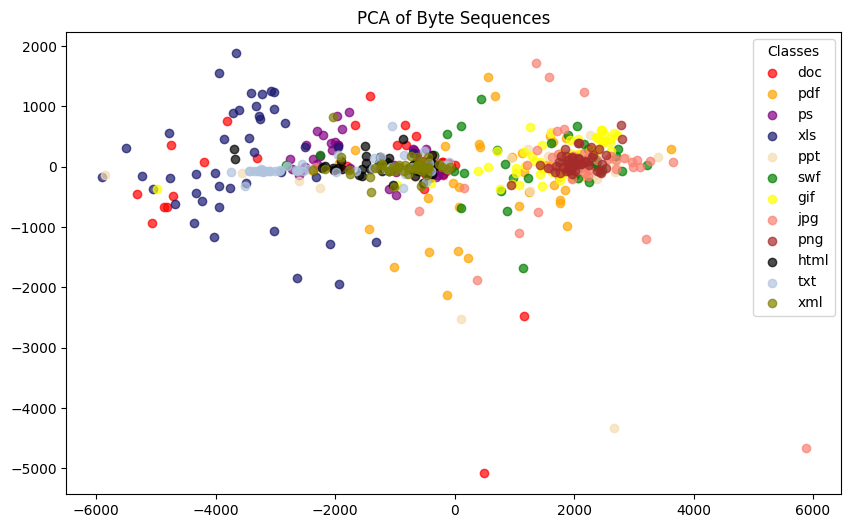

In [58]:
plot_pca(X_body_block, y_body_block, CLASS_NAMES, "PCA of Byte Sequences")

### t-SNE plot of Byte Sequences

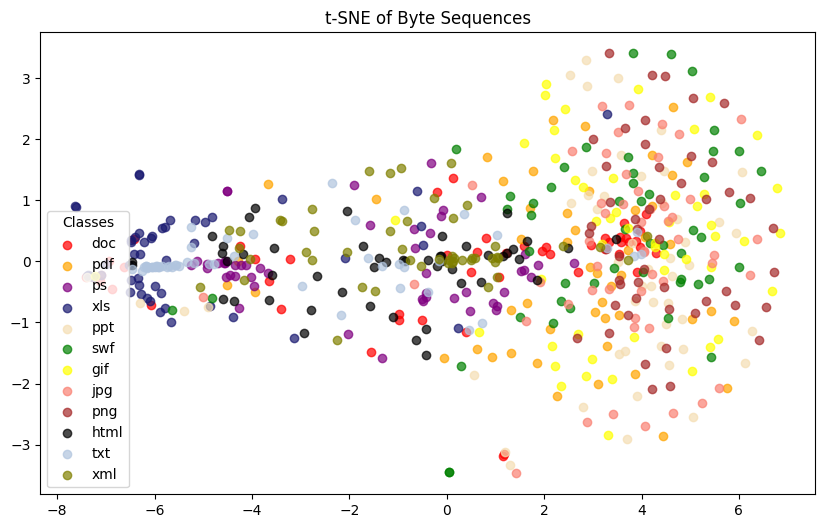

In [59]:
plot_tsne(X_body_block, y_body_block, CLASS_NAMES, "t-SNE of Byte Sequences")

In [60]:
def visualise_byte_sequences(class_names: list) -> None:
    """
    Genarates a Grey scale plot for 2 file samples of the same type. 
    Repeats the process for all given file types.

    Args:
        class_names (list): A list of file types.
    """
    print("=" * 120 + "\n" + "\t" * 6 + "BODY BLOCK\n" + "=" * 120)
    for i in range(len(class_names)):

        print("FILE TYPE: ", f"\"{class_names[i]}\"", "\n")
        random_idx1 = np.random.randint(0, 1000)
        random_idx2 = np.random.randint(0, 1000)

        print(df[df["type"] == CLASS_NAMES[i]]["file"].iloc[random_idx1])
        plot_byte_grey_scale(df[df["type"] == CLASS_NAMES[i]]["body_block_bytes"].iloc[random_idx1])
        print(df[df["type"] == CLASS_NAMES[i]]["file"].iloc[random_idx2])
        plot_byte_grey_scale(df[df["type"] == CLASS_NAMES[i]]["body_block_bytes"].iloc[random_idx2])

        print("-" * 60)

### Byte Sequence Grey Scale plots

						BODY BLOCK
FILE TYPE:  "doc" 

380693.doc


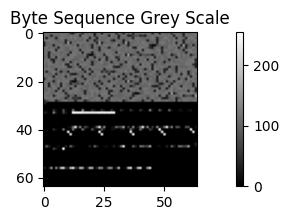

335003.doc


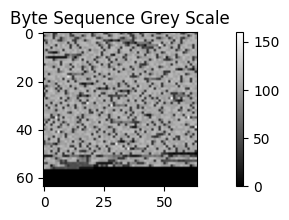

------------------------------------------------------------
FILE TYPE:  "pdf" 

401177.pdf


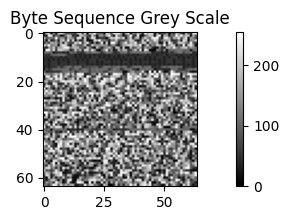

281762.pdf


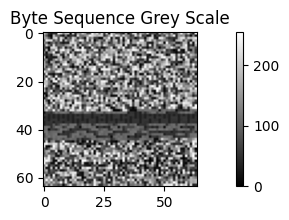

------------------------------------------------------------
FILE TYPE:  "ps" 

378153.ps


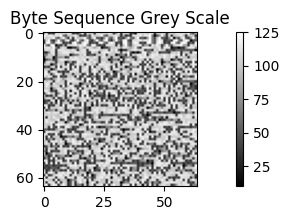

314196.ps


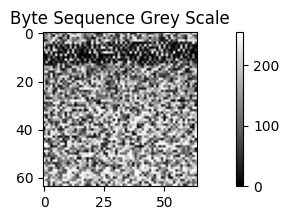

------------------------------------------------------------
FILE TYPE:  "xls" 

161513.xls


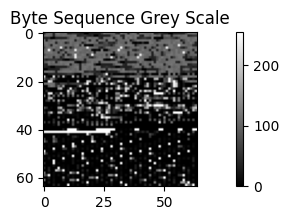

075247.xls


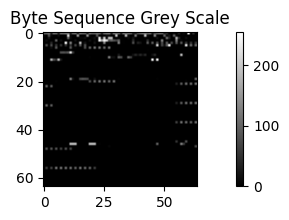

------------------------------------------------------------
FILE TYPE:  "ppt" 

107137.ppt


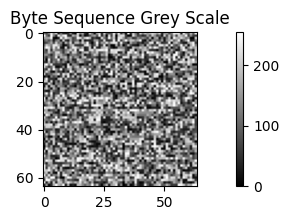

248669.ppt


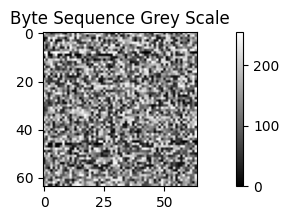

------------------------------------------------------------
FILE TYPE:  "swf" 

636383.swf


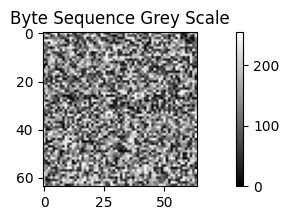

588822.swf


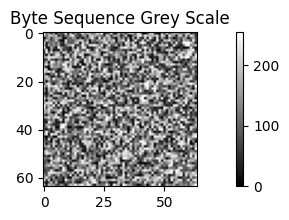

------------------------------------------------------------
FILE TYPE:  "gif" 

094907.gif


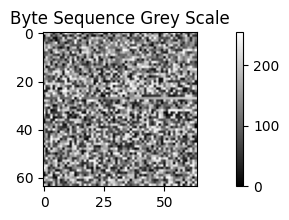

693340.gif


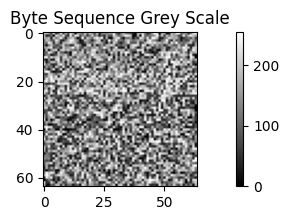

------------------------------------------------------------
FILE TYPE:  "jpg" 

709826.jpg


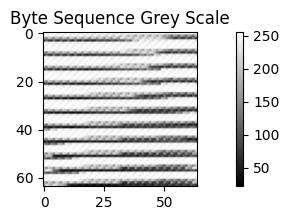

404265.jpg


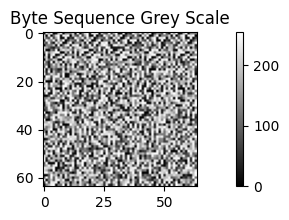

------------------------------------------------------------
FILE TYPE:  "png" 

035439.png


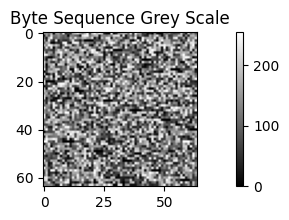

167566.png


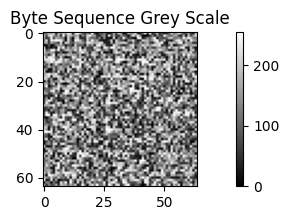

------------------------------------------------------------
FILE TYPE:  "html" 

291548.html


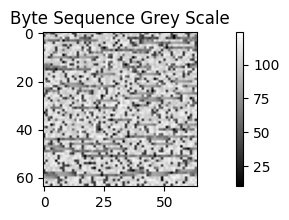

276193.html


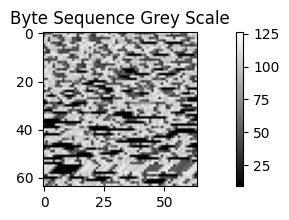

------------------------------------------------------------
FILE TYPE:  "txt" 

364452.txt


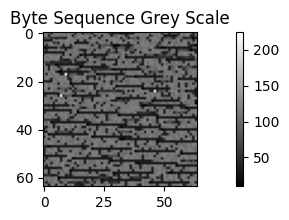

396038.txt


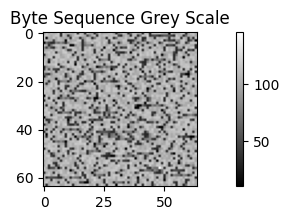

------------------------------------------------------------
FILE TYPE:  "xml" 

560789.xml


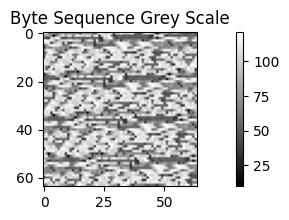

585509.xml


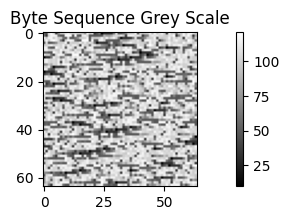

------------------------------------------------------------


In [61]:
visualise_byte_sequences(CLASS_NAMES)

2. Creating Byte Frequency Histogram Arrays

In [62]:
df_subset["body_block_bfh"] = df_subset["body_block_bytes"].apply(
    lambda byte_sequence: byte_frequency_histogram(np.array([b for b in byte_sequence]))
)
df_subset.sample(n=5)

,file,type,size KB,1st_block_bytes,body_block_bytes,last_block_bytes,class,body_block_bfh
302,155175.gif,gif,18.240234,b'GIF89a\xd8\x00\x92\x00\xf7\x00\x00\xff\xff\x...,b'FG\xb0\xd1(\xb3\xa66\xb6ak2$q7d\x1c\x89\x19\...,b'\xf03 \xc3\x1f<\xc33\x94\x8f*@\xc3N\x00\xb9\...,7,"[32, 16, 45, 31, 27, 33, 25, 19, 33, 22, 30, 2..."
462,531368.html,html,50.638672,"b'<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 ...",b'/A></TD><TD><I>Alnus serrulata </I></TD><TD>...,b'D>Histograms</TD><TD>&nbsp;</TD><TD>&nbsp;</...,10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0,..."
357,086401.jpg,jpg,156.853516,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\xa74\xff\x00\nK\xdf\nhl\xa6K}\x0fO\nG+\xf6d...,b'Z\xe7s`\xf3\xde\x8a+[\xd9;\x15K\xe0:\xf6\x85...,8,"[23, 10, 5, 18, 13, 17, 12, 14, 11, 12, 22, 12..."
56,105046.pdf,pdf,49.567383,b'%PDF-1.2 \r%\xe2\xe3\xcf\xd3\r\n \r10 0 obj\...,"b'Z\x9aE?2{\xe8\x19De_`\xdf\x91n\xb4\xe9,GF\x9...",b'3000300033002E0064006F00630020002D0020004D00...,2,"[13, 15, 15, 14, 23, 16, 15, 10, 14, 14, 10, 1..."
401,701727.png,png,118.866211,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x81+\xc2\x84\x10\xec\x03x\xd4\xb8\xcb%\xe9O...,b'\x06\xf3\x1e\xad\x9e\xd0t\xe8B\x9ex59\x00\x8...,9,"[23, 13, 20, 10, 20, 16, 15, 25, 12, 13, 12, 1..."


### Correlation Matrix of Byte Frequency Histograms

In [63]:
body_block_bfh_df = pd.DataFrame(df_subset['body_block_bfh'].tolist())
body_block_bfh_df.columns = [f'bytes_count_{i}' for i in range(body_block_bfh_df.shape[1])]
body_block_bfh_df = pd.concat([df_subset[['class']], body_block_bfh_df], axis=1)
body_block_bfh_df.sample(n=5)

,class,bytes_count_0,bytes_count_1,bytes_count_2,bytes_count_3,bytes_count_4,bytes_count_5,bytes_count_6,bytes_count_7,bytes_count_8,...,bytes_count_246,bytes_count_247,bytes_count_248,bytes_count_249,bytes_count_250,bytes_count_251,bytes_count_252,bytes_count_253,bytes_count_254,bytes_count_255
531,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,1,0,10,0,0,0,0,0,21,0,...,0,0,0,0,0,0,0,0,0,0
585,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
591,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
417,9,20,23,23,20,29,12,13,20,24,...,14,18,18,21,19,15,18,16,12,16


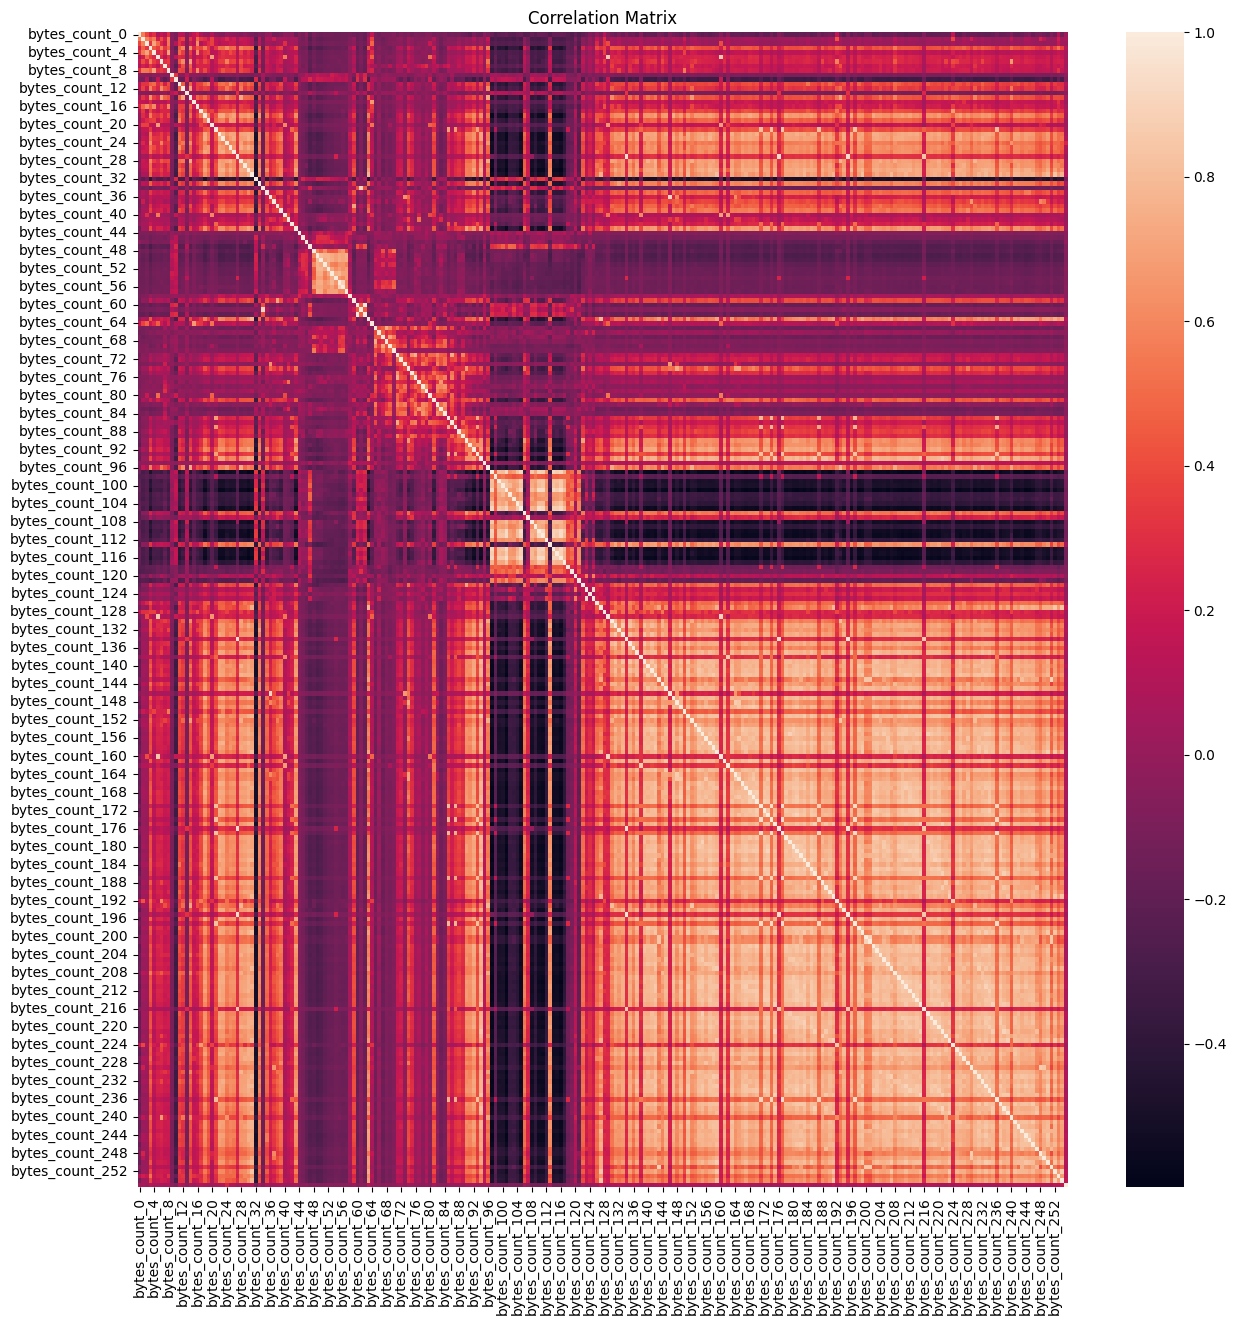

In [64]:
corr_matrix = body_block_bfh_df.loc[:, "bytes_count_0": "bytes_count_255"].corr()
correlation_matrix_heatmap(corr_matrix)

### PCA of Byte Frequency Histograms

In [65]:
X_body_block_bfh = np.array([np.array([b for b in x]) for x in df_subset["body_block_bfh"]])
y_body_block_bfh = np.array([y for y in df_subset["class"]])

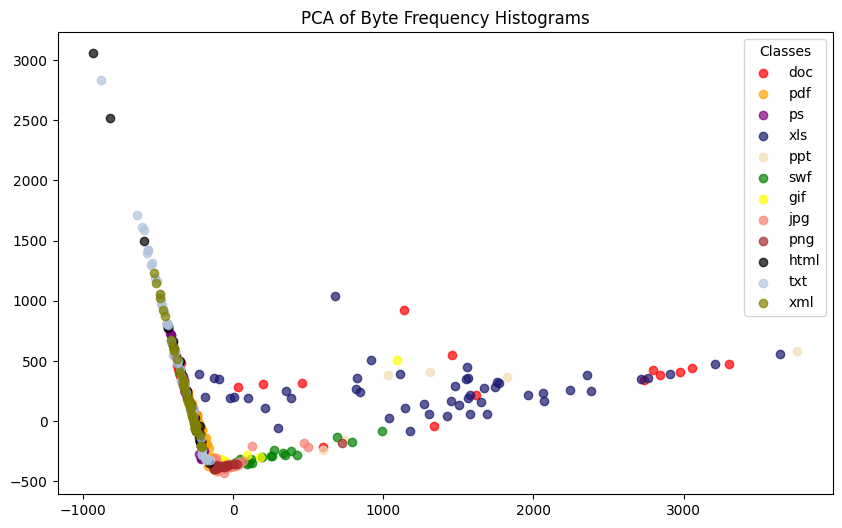

In [66]:
plot_pca(X_body_block_bfh, y_body_block_bfh, CLASS_NAMES, "PCA of Byte Frequency Histograms")

### t-SNE of Byte Frequency Histograms

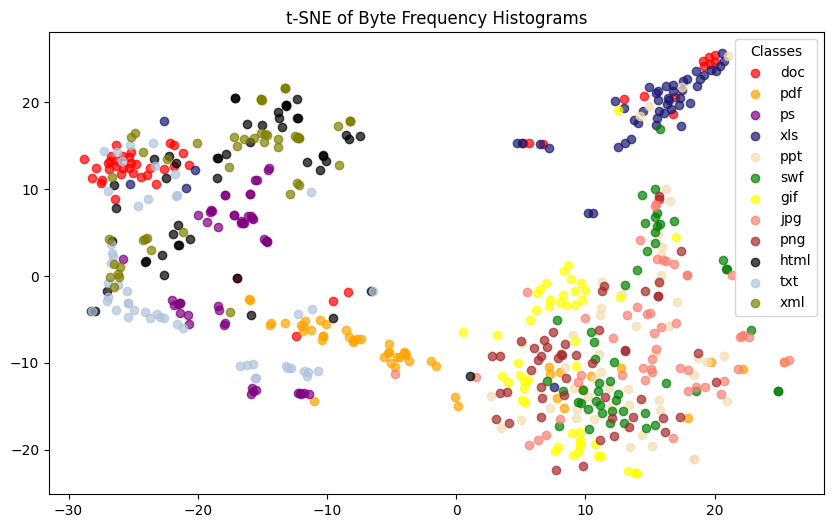

In [67]:
plot_tsne(X_body_block_bfh, y_body_block_bfh, CLASS_NAMES, "t-SNE of Byte Frequency Histograms")

### Byte Value Distribution plots

In [68]:
def plot_byte_value_distributions(class_names: list) -> None:
    """
    Genarates a Byte value distribution plot for 2 file samples of 
    the same type. Repeats the process for all given file types.

    Args:
        class_names (list): A list of file types.
    """
    print("=" * 120 + "\n" + "\t" * 6 + "BODY BLOCK\n" + "=" * 120)
    for i in range(len(class_names)):

        print("FILE TYPE: ", f"\"{class_names[i]}\"", "\n")
        random_idx1 = np.random.randint(0, 1000)
        random_idx2 = np.random.randint(0, 1000)

        print(df[df["type"] == CLASS_NAMES[i]]["file"].iloc[random_idx1])
        plot_byte_value_distribution(df[df["type"] == CLASS_NAMES[i]]["body_block_bytes"].iloc[random_idx1])

        print(df[df["type"] == CLASS_NAMES[i]]["file"].iloc[random_idx2])
        plot_byte_value_distribution(df[df["type"] == CLASS_NAMES[i]]["body_block_bytes"].iloc[random_idx2])

        print("-" * 60)

						BODY BLOCK
FILE TYPE:  "doc" 

514230.doc


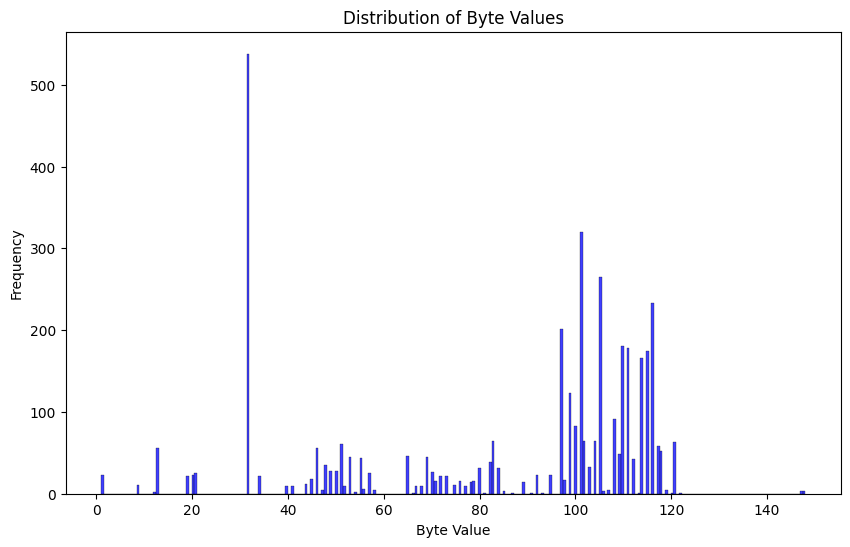

700717.doc


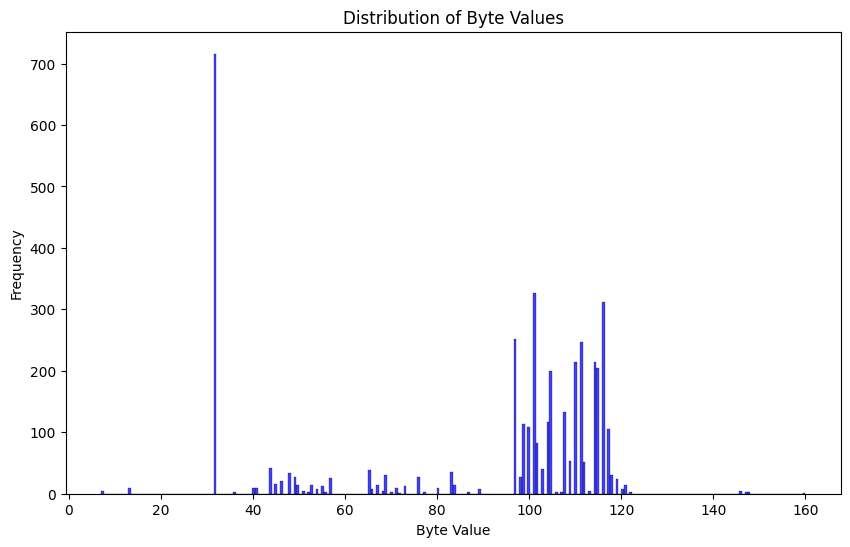

------------------------------------------------------------
FILE TYPE:  "pdf" 

689229.pdf


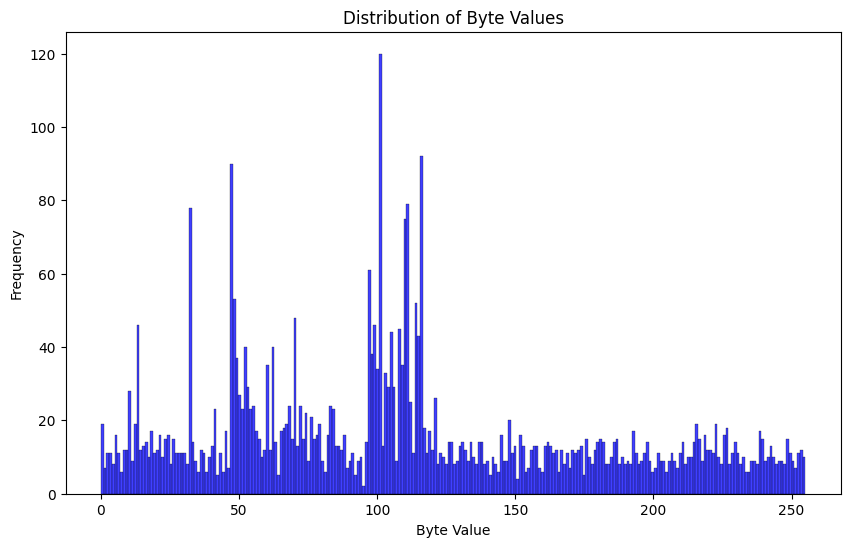

560616.pdf


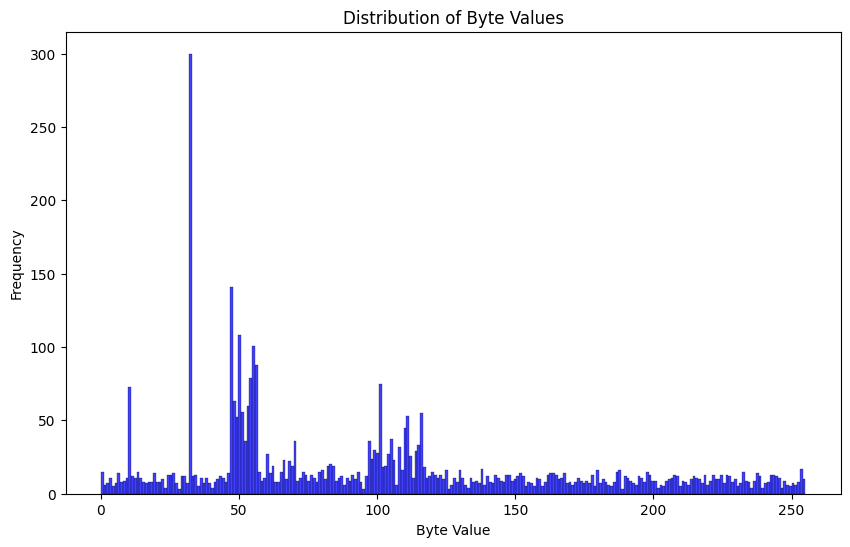

------------------------------------------------------------
FILE TYPE:  "ps" 

439733.ps


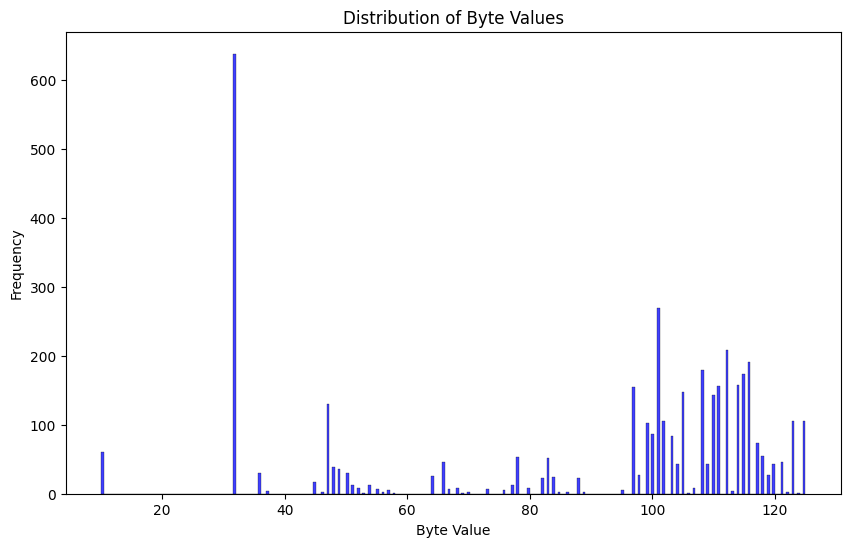

356000.ps


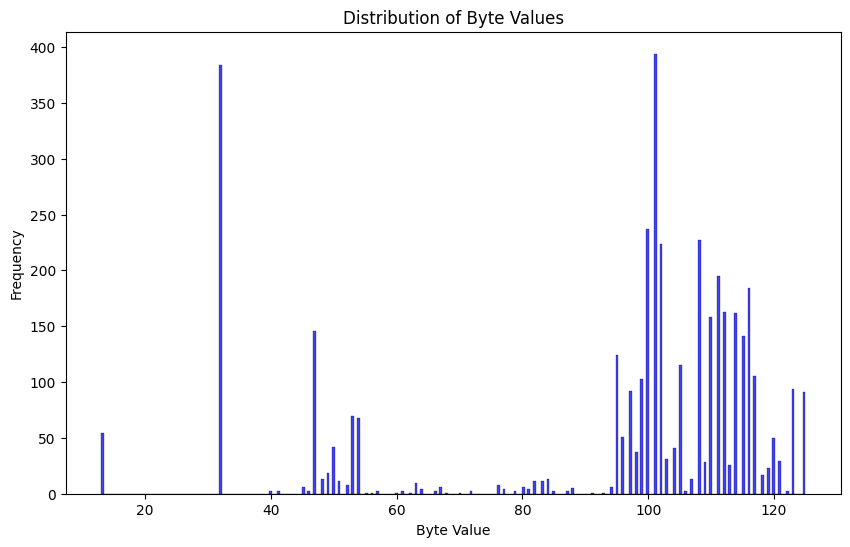

------------------------------------------------------------
FILE TYPE:  "xls" 

048695.xls


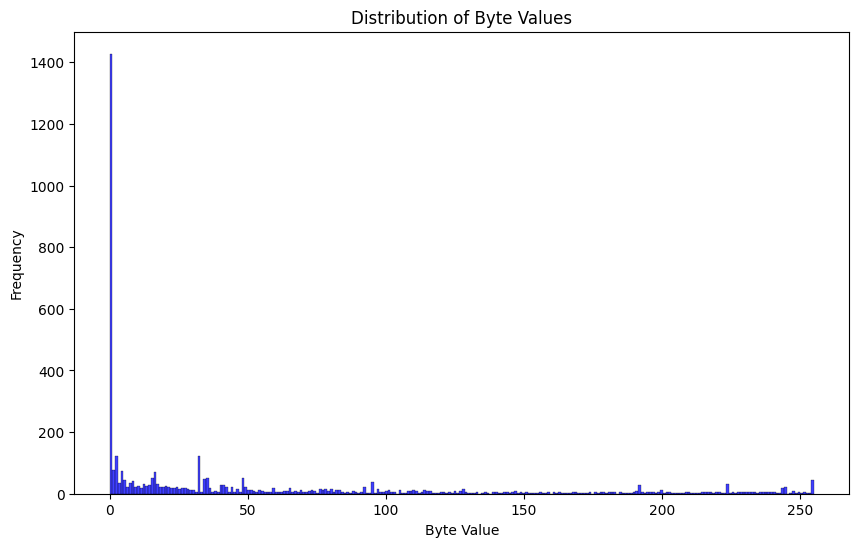

643550.xls


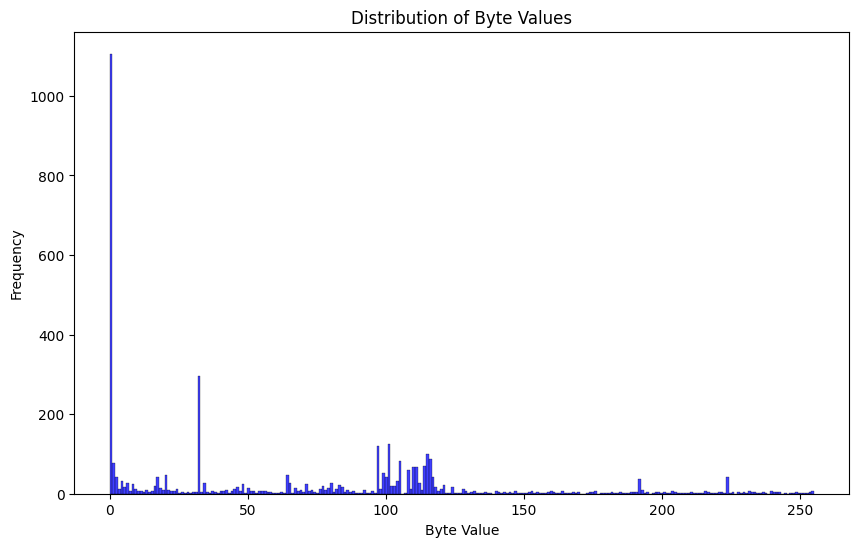

------------------------------------------------------------
FILE TYPE:  "ppt" 

023031.ppt


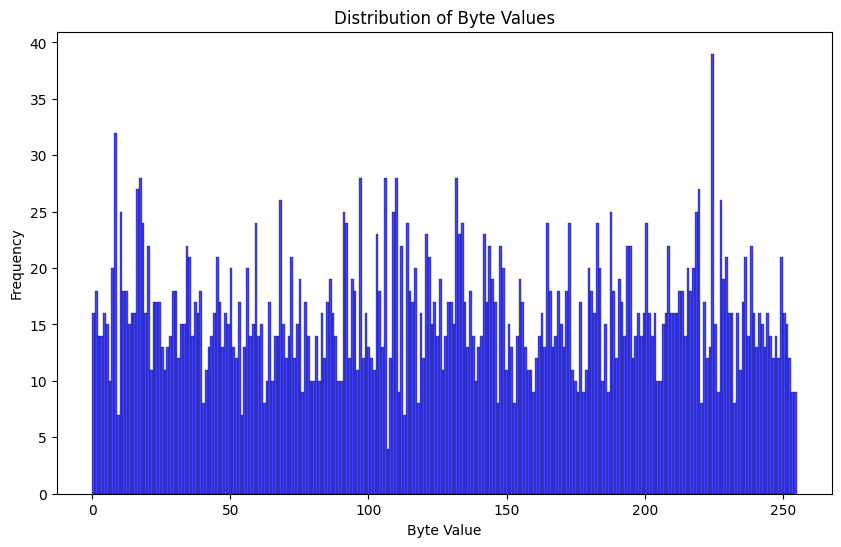

016835.ppt


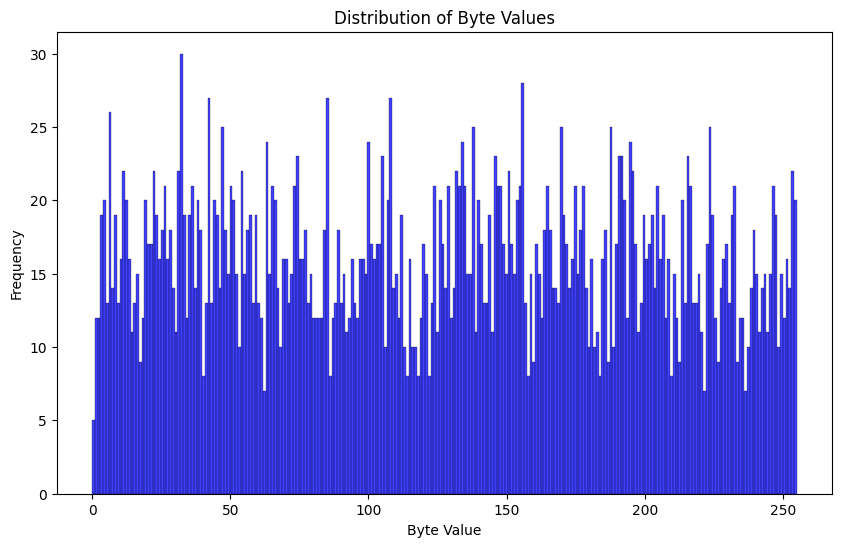

------------------------------------------------------------
FILE TYPE:  "swf" 

485246.swf


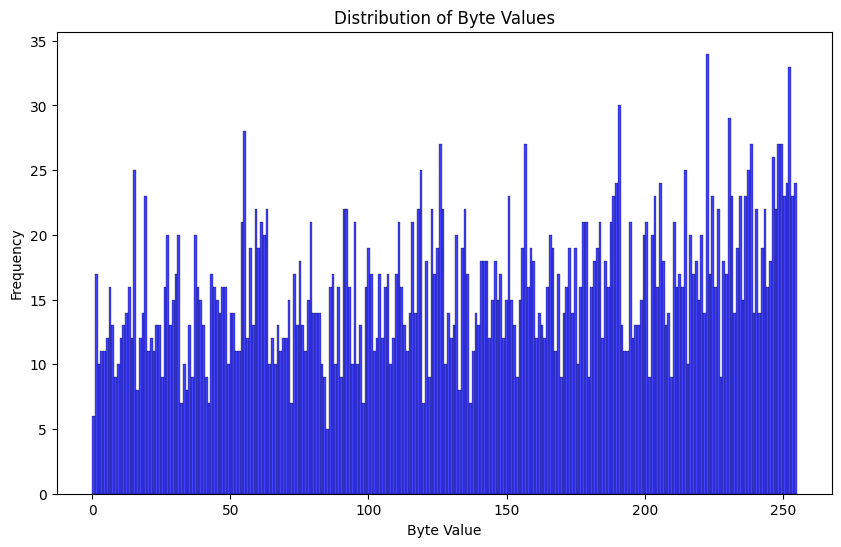

579496.swf


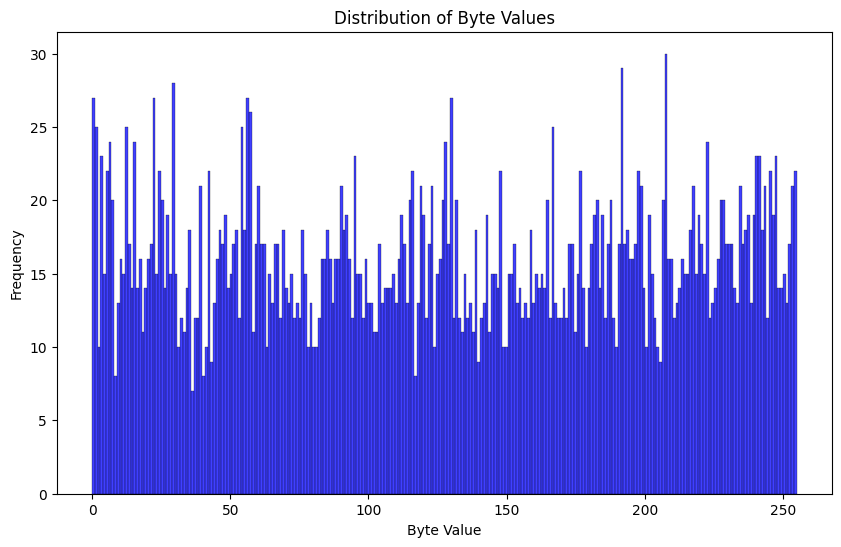

------------------------------------------------------------
FILE TYPE:  "gif" 

696053.gif


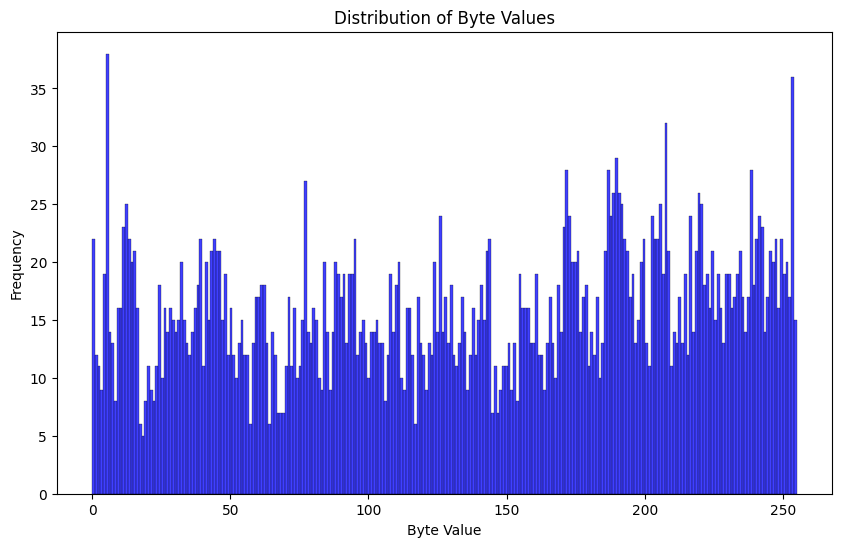

049208.gif


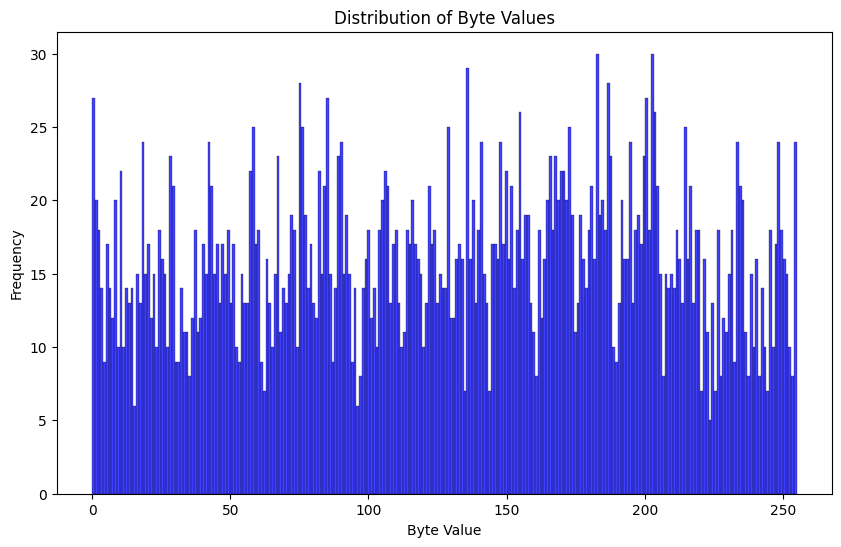

------------------------------------------------------------
FILE TYPE:  "jpg" 

288603.jpg


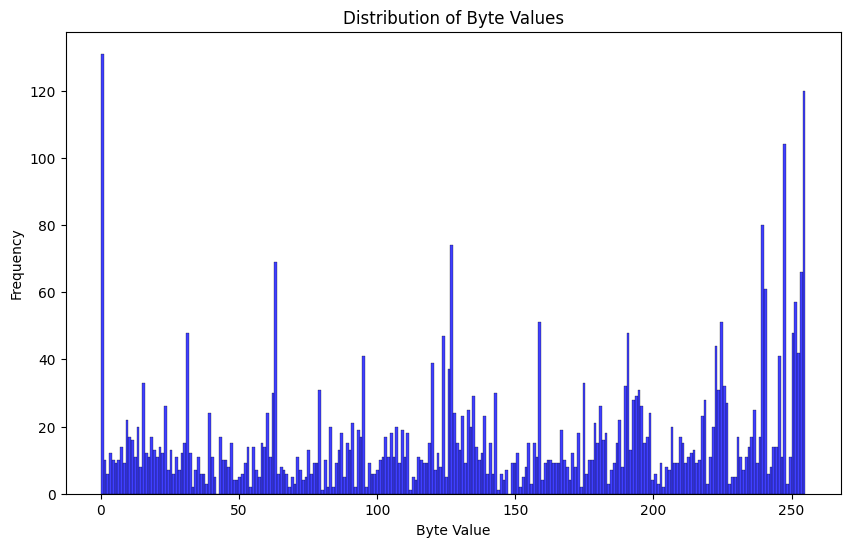

221298.jpg


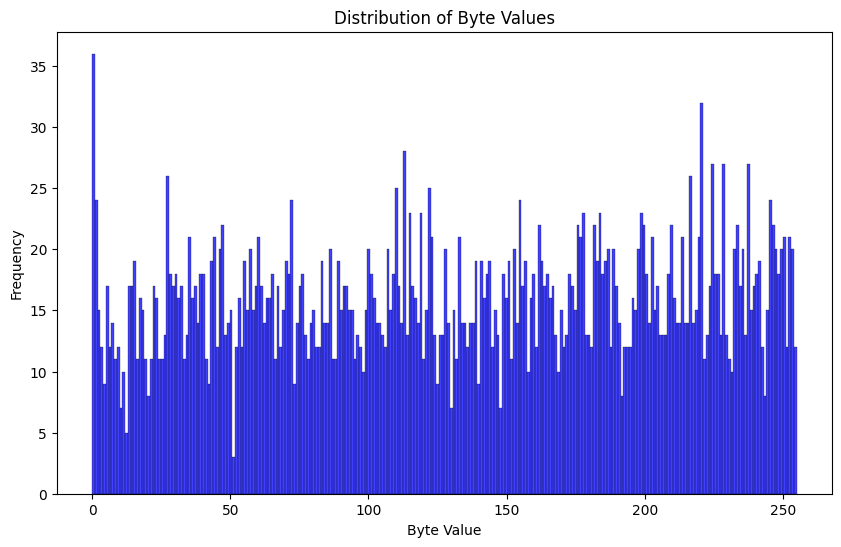

------------------------------------------------------------
FILE TYPE:  "png" 

304310.png


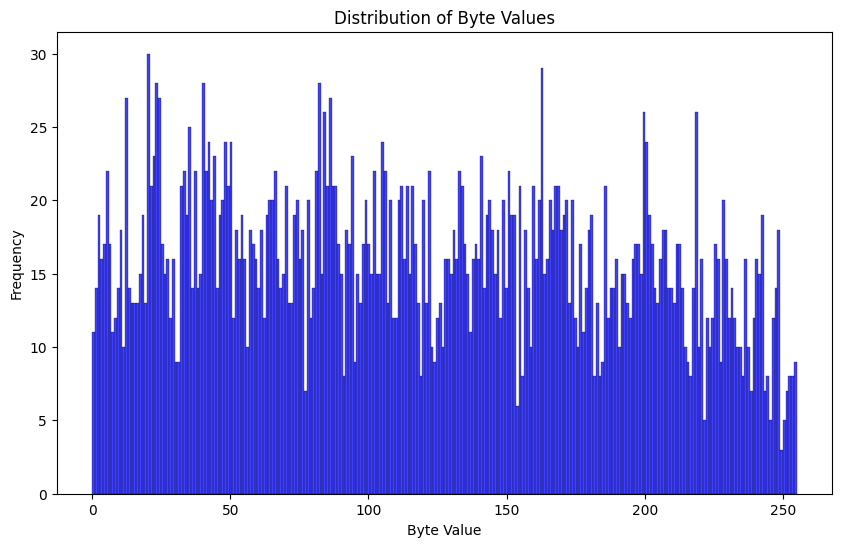

441431.png


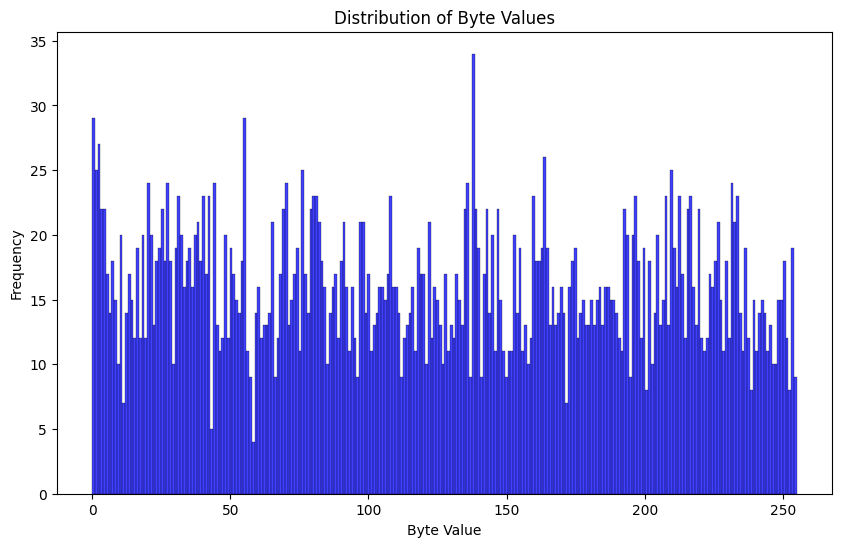

------------------------------------------------------------
FILE TYPE:  "html" 

714746.html


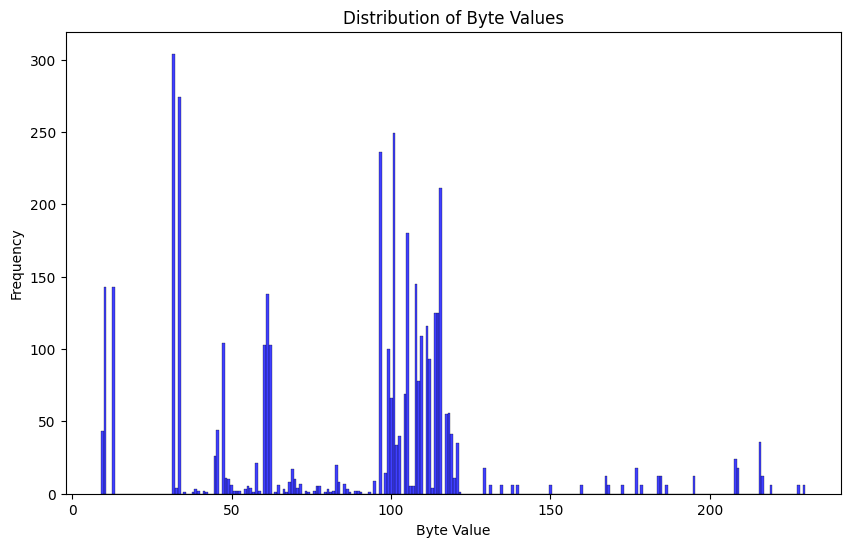

311491.html


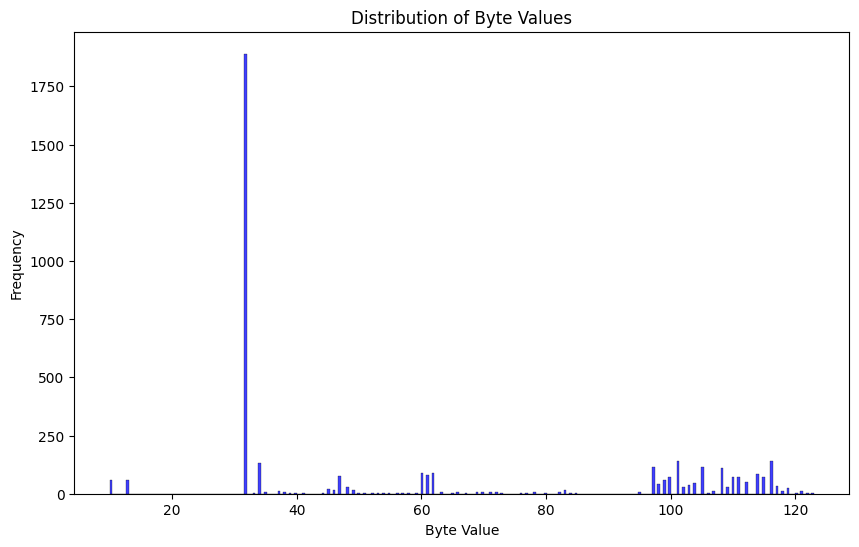

------------------------------------------------------------
FILE TYPE:  "txt" 

675901.txt


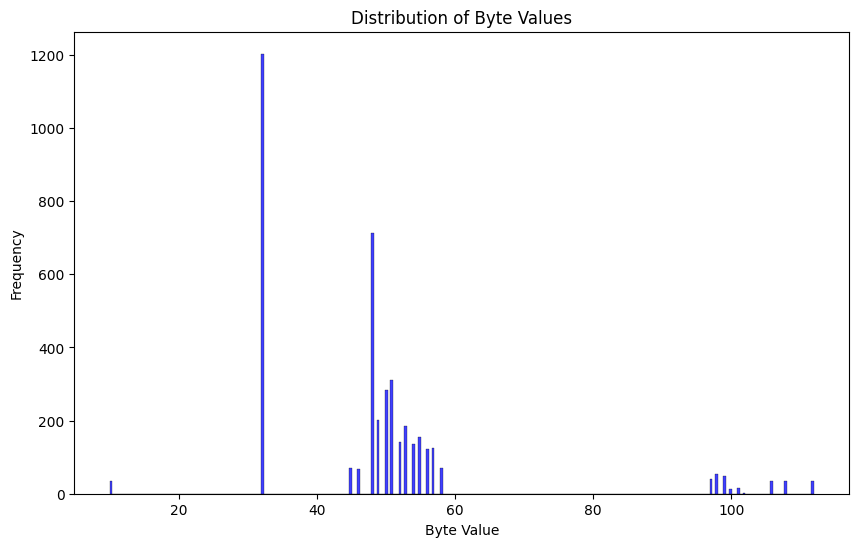

122129.txt


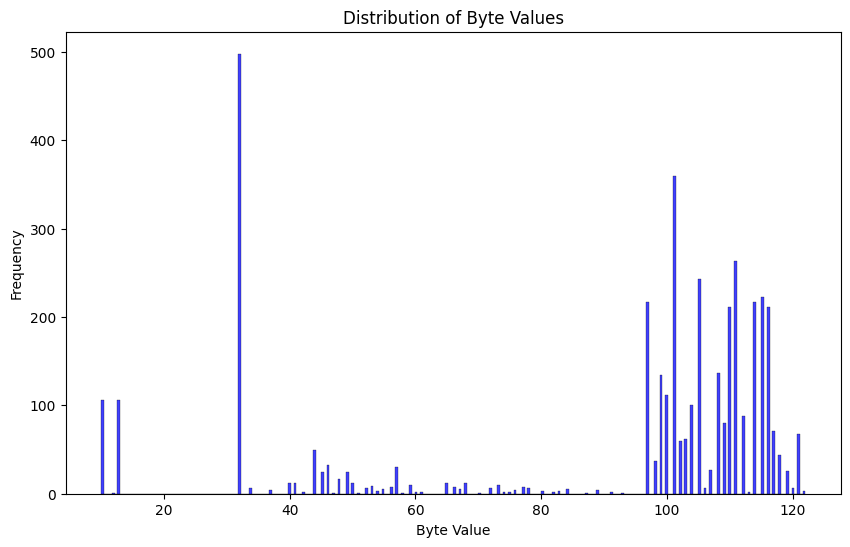

------------------------------------------------------------
FILE TYPE:  "xml" 

672141.xml


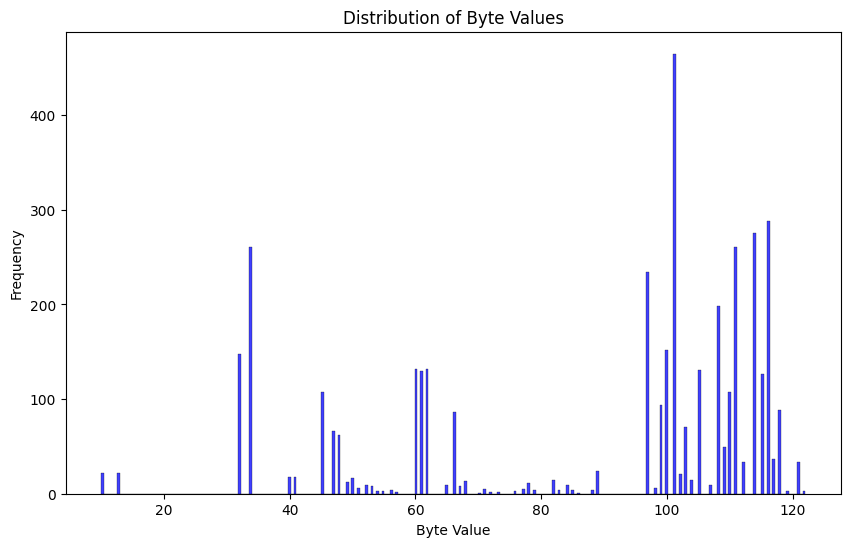

358440.xml


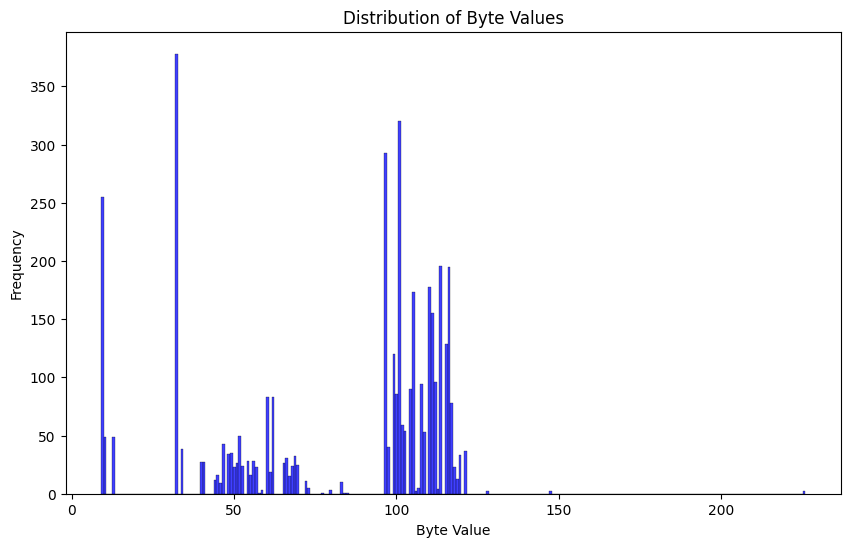

------------------------------------------------------------


In [69]:
plot_byte_value_distributions(CLASS_NAMES)